## Inital Env

Notes: `Rtools` is required to be installed to use `Rcpp` package. Here is an instruction for installing "[Rtools42 for Windows](https://cran.r-project.org/bin/windows/Rtools/rtools42/rtools.html)".

In [1]:
rm(list = ls())

library(data.table)
library(ggplot2)
library(dtw)
library(Rcpp)
# getwd()
sourceCpp("shapeDTW_translate/dpcore.cpp")

# global settings
options(repr.plot.width=16, repr.plot.height=6)

Loading required package: proxy


Attaching package: 'proxy'


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Loaded dtw v1.23-1. See ?dtw for help, citation("dtw") for use in publication.




## Load Data

[1] 312   3


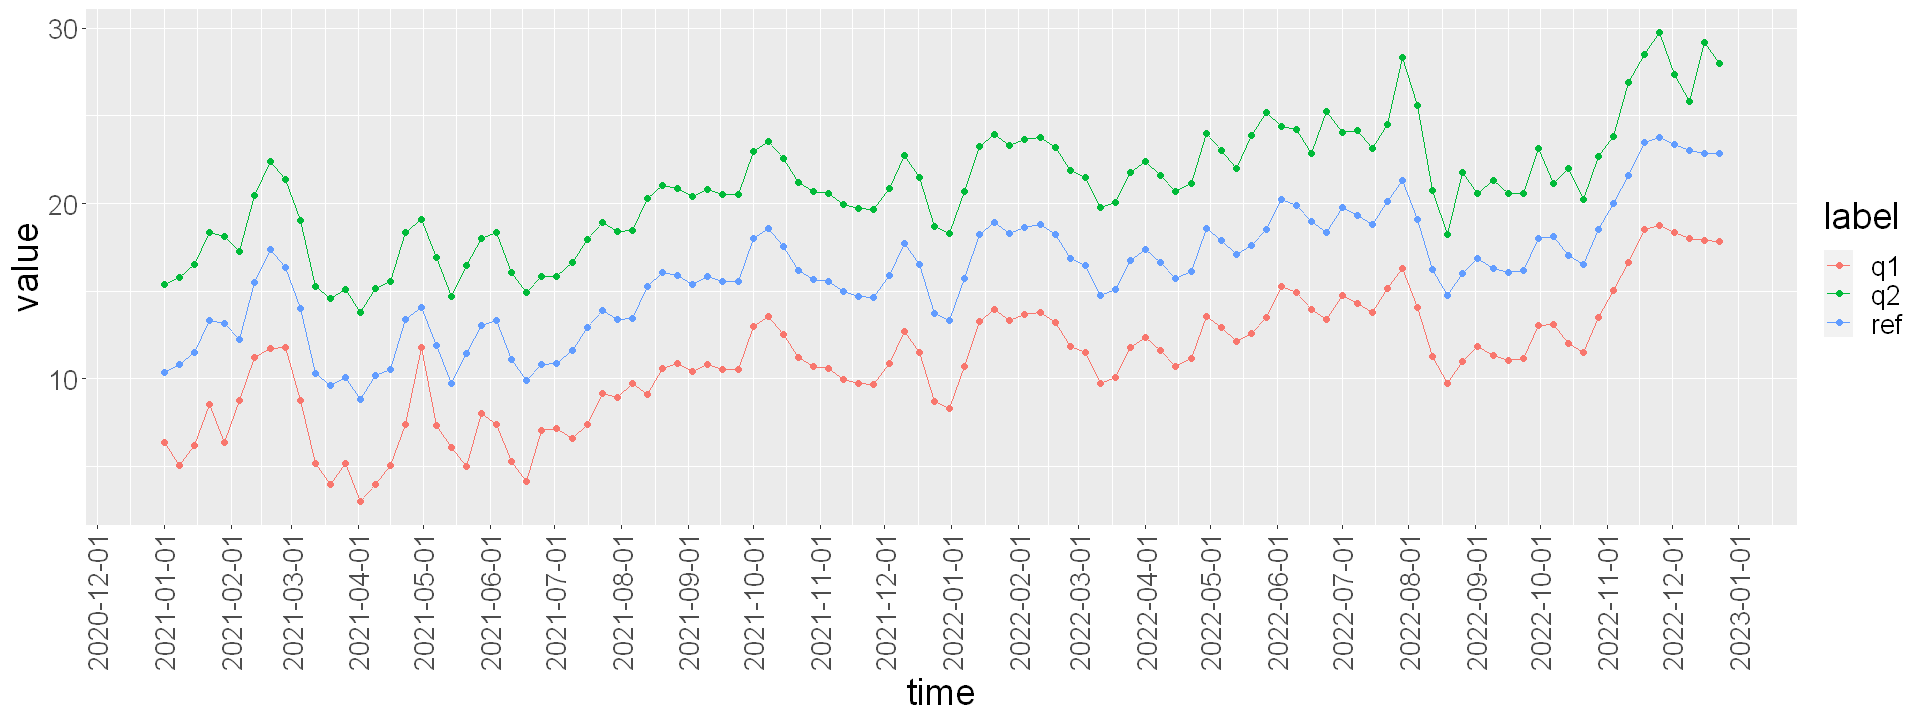

In [2]:
dt <- fread('testdata.csv')
print(dim(dt))

ggplot(data=dt, aes(x=time, y=value, color=label)) + geom_point() + geom_line() + 
scale_x_date(breaks="1 month") + theme(
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1),
    axis.title=element_text(size=22), axis.text=element_text(size=16), 
    legend.title=element_text(size=22), legend.text=element_text(size=16))

## Weight Function

+ $A = (a_1, a_2, \dots, a_m)$

+ $B = (b_1, b_2, \dots, b_n)$

+ Modified Logistic Weights for ($a_i$, $b_j$)
    + **Relative Position**
        $$w_{i,j}^r = \frac{w_{\max}}{1+\exp(-g(|i-j|-m_c)}=\frac{w_{\max}}{1+\exp(-g\cdot |i-j|)\cdot\exp(g\cdot m_c)}$$
        where $w_\max=1$ and $m_c=m/2$.
        + This is a weight implying the penalty for matching two points from different time periods. The larger the weight, the further two points are away from each other.
    
    + **Absolute Position**
        $$w_{i,j}^a = \frac{w_{\max}}{1+\exp(-g([{\rm mean}(i,j)-0]-m_c)}=\frac{w_{\max}}{1+\exp(-g\cdot {\rm mean}(i,j))\cdot\exp(g\cdot m_c)}$$
        where $w_\max=1$ and $m_c=m/2$.
        
    + How to Combine Two Weights
        1. Harmonic Mean (non-monotonic graph implies this is a bad idea)
            $$w_{i,j}=\frac{2}{1/w_{i,j}^r + 1/w_{i,j}^a}$$
        2. Based on relative-position weights find the best path and apply absolute-position weights to the best path

In [3]:
weight_fcn <- function(i, j, m, type, g=0.1, w_max=1) {
    
    if (!type %in% c('relative', 'absolute')) {
        stop("type should be either 'relative' or 'absolute'")
    }
    
    m_c = round(m/2, 0)
    idx_diff = (type == 'relative') * abs(i-j) + (type == 'absolute') * mean(c(i,j))
    
    weight = w_max / (1 + exp(-g *(idx_diff - m_c)) )
    return(weight)
}

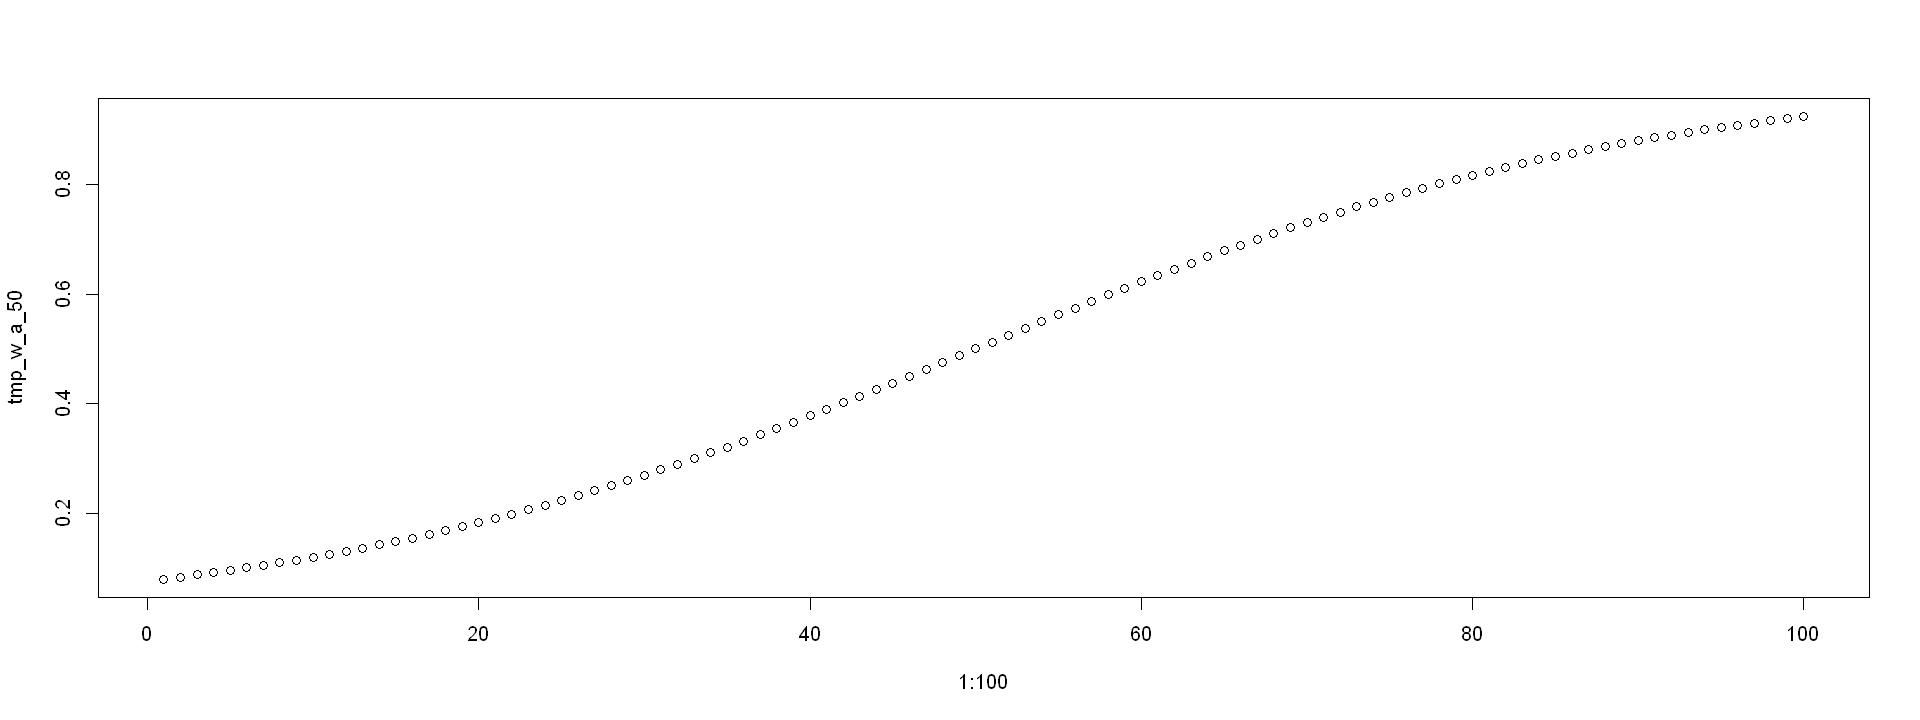

In [4]:
tmp_w_a_50 <- sapply(c(1:100), function (x) weight_fcn(x, 50, 100, type='absolute'))
plot(1:100, tmp_w_a_50)

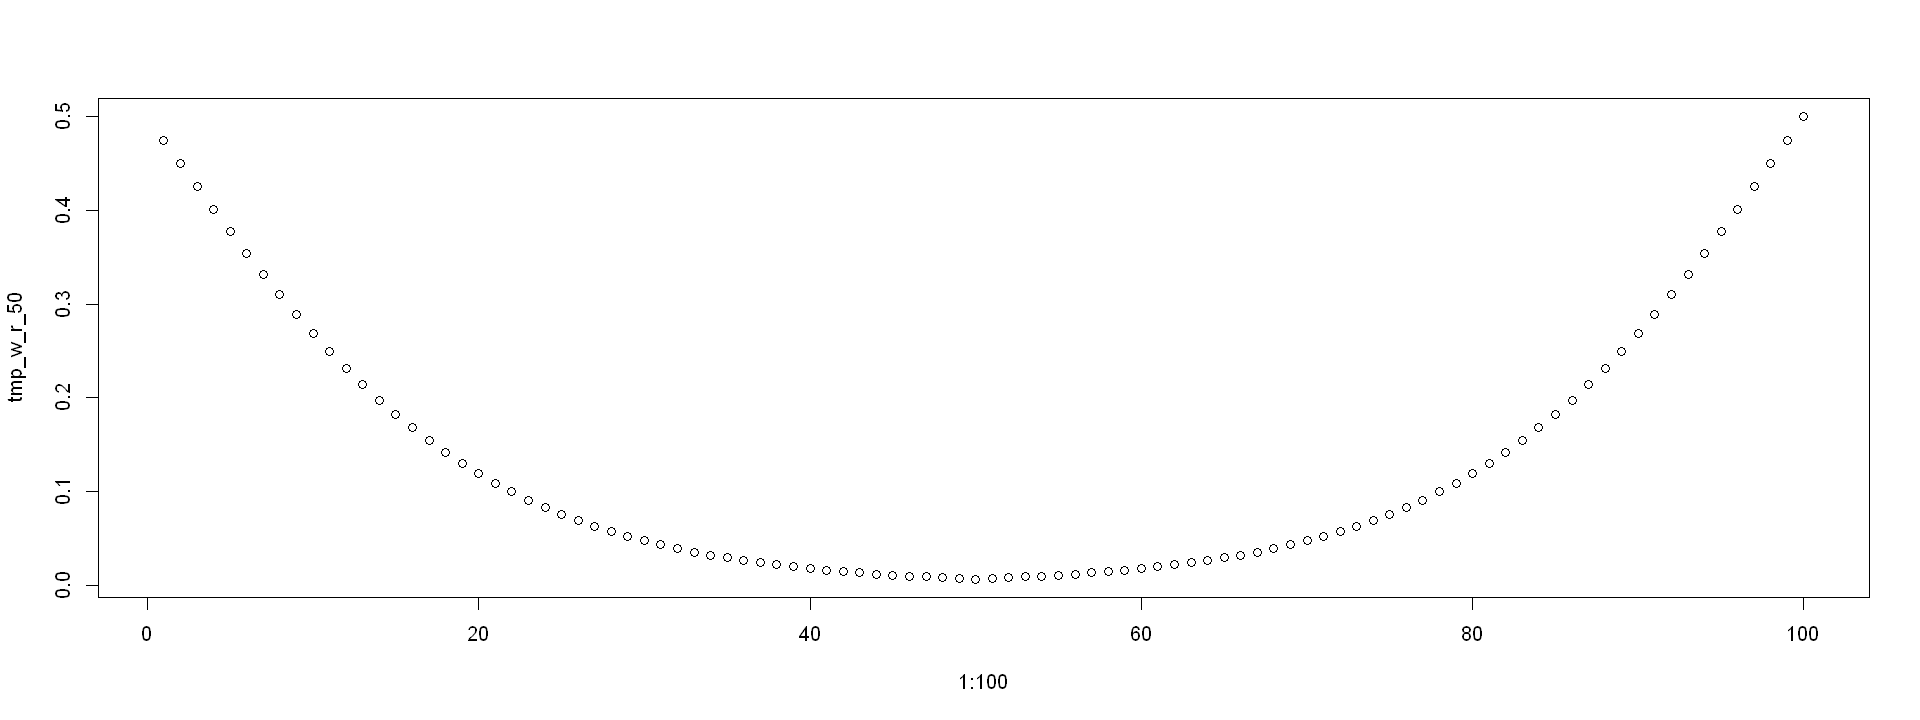

In [5]:
tmp_w_r_50 <- sapply(c(1:100), function (x) weight_fcn(x, 50, 100, type='relative'))
plot(1:100, tmp_w_r_50)

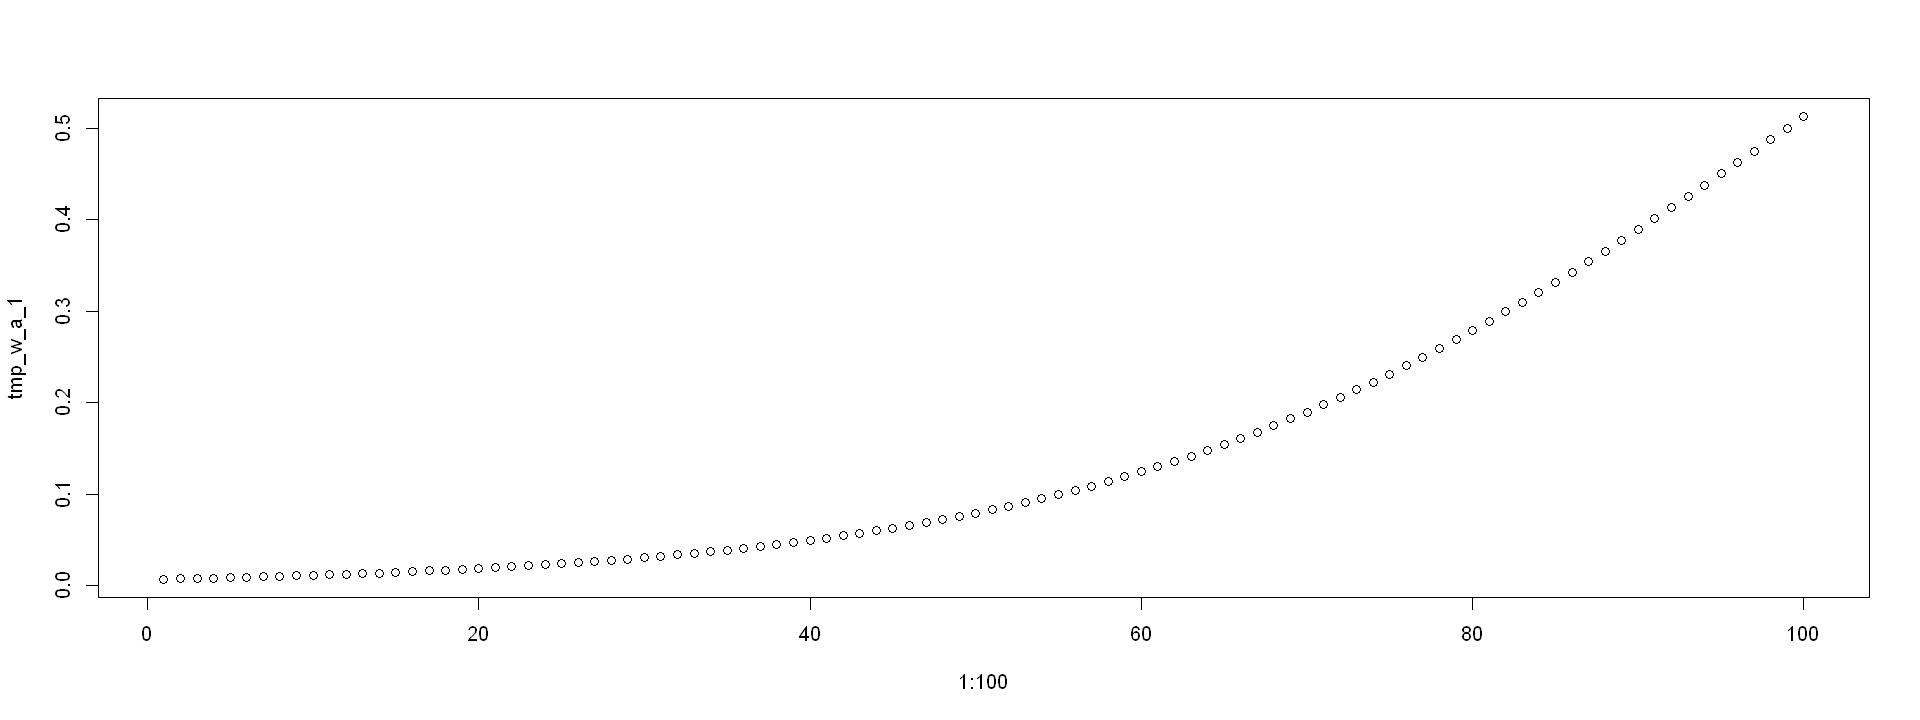

In [6]:
tmp_w_a_1 <- sapply(c(1:100), function (x) weight_fcn(x, 1, 100, type='absolute'))
plot(1:100, tmp_w_a_1)

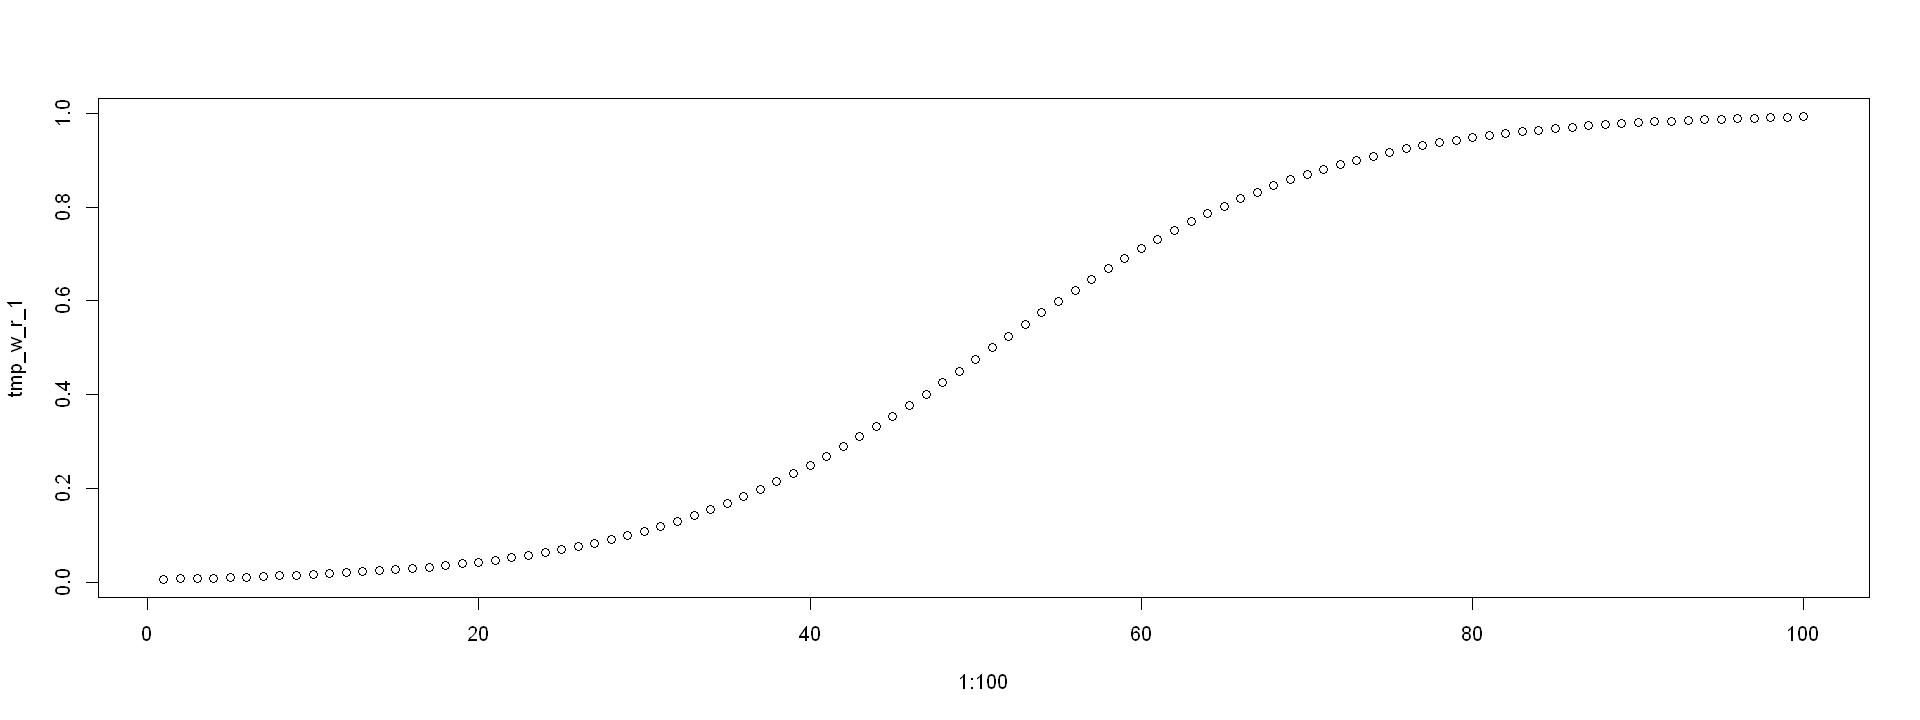

In [7]:
tmp_w_r_1 <- sapply(c(1:100), function (x) weight_fcn(x, 1, 100, type='relative'))
plot(1:100, tmp_w_r_1)

## Distance Functions

In [8]:
dist2_wt <- function(x, c, wt_func) {
    # Get the number of data points and dimensions in x
    ndata <- nrow(x)
    dimx <- ncol(x)
    
    # Get the number of centres and dimensions in c
    ncentres <- nrow(c)
    dimc <- ncol(c)
    
    # Check that the dimensions of x and c match
    if (dimx != dimc) {
        stop("Data dimension does not match dimension of centres")
    }
    
    # Calculate the squared Euclidean distance between each data point in x and each centre in c
    n2 <- matrix(0, nrow = ndata, ncol = ncentres)
    
    if (missing(wt_func)) {
        for (i in 1:ncentres) {
            n2[, i] <- sqrt(colSums((t(x) - t(c)[, i])^2)) # 
        }
    } else {
        for (i in 1:ncentres) {
            w_i <- wt_func(i=i, j=1:ndata, m=ndata, type='relative')
            n2[, i] <- sqrt(rowSums((w_i * t(t(x) - t(c)[, i]))^2)) # 
        }
    }
    
    return(n2)
}

In [9]:
head(dt)

time,label,value
<date>,<chr>,<dbl>
2021-01-01,ref,10.37722
2021-01-08,ref,10.79246
2021-01-15,ref,11.50489
2021-01-22,ref,13.33110
2021-01-29,ref,13.13147
2021-02-05,ref,12.24382


In [10]:
seq_ref <- as.matrix(dt[label=='ref']$value)
seq_q1 <- as.matrix(dt[label=='q1']$value)
seq_q2 <- as.matrix(dt[label=='q2']$value)
cat(paste0('Dim of seq_ref: ', paste(dim(seq_ref), collapse=' X '),
           '\nDim of seq_q1: ', paste(dim(seq_q1), collapse=' X '),
           '\nDim of seq_q2: ', paste(dim(seq_q2), collapse=' X ')))

Dim of seq_ref: 104 X 1
Dim of seq_q1: 104 X 1
Dim of seq_q2: 104 X 1

In [11]:
M_1 <- dist2_wt(x=seq_ref, c=seq_q1)
M_1_wt <- dist2_wt(x=seq_ref, c=seq_q1, wt_func=weight_fcn)
M_2 <- dist2_wt(x=seq_ref, c=seq_q2)
M_2_wt <- dist2_wt(x=seq_ref, c=seq_q2, wt_func=weight_fcn)

In [12]:
# [p,q,D,sc] = dpfast(M,C,T,G)
#    Use dynamic programming to find a min-cost path through matrix M.
#    Return state sequence in p,q; full min cost matrix as D and 
#    local costs along best path in sc.
#    This version gives the same results as dp.m, but uses dpcore.mex
#    to run ~200x faster.
#    C is a step matrix, with rows (i step, j step, cost factor)
#    Default is [1 1 1.0;0 1 1.0;1 0 1.0];
#    symmetric2 in dtw package [1 1 2.0;0 1 1.0;1 0 1.0];
#    Another good one is [1 1 1;1 0 1;0 1 1;1 2 2;2 1 2]
#    T selects traceback origin: 0 is to any edge; 1 is top right (default);
#    T > 1 finds path to min of anti-diagonal T points away from top-right.
#    Optional G defines length of 'gulleys' for T=0 mode; default 0.5
#    (i.e. accept path to only 50% of edge nearest top-right)
# 2003-04-04,2005-04-04 dpwe@ee.columbia.edu $Header: /Users/dpwe/projects/dtw/RCS/dpfast.m,v 1.6 2008/03/14 14:40:50 dpwe Exp dpwe $
  
  # Copyright (c) 2003 Dan Ellis <dpwe@ee.columbia.edu>
  # released under GPL - see file COPYRIGHT

dpfast <- function(M, C, T=1, G=0.5) {
    if (missing(M)) {
        stop("Error: M is missing")
    }
    
    # Default step / cost matrix
    if (missing(C)) {
        C = matrix(c(1, 1, 1.0, 0, 1, 1.0, 1, 0, 1.0), ncol=3, byrow=TRUE)
    }
    
    # Default: path to top-right
    if (missing(T)) {
        T = 1
    }
    
    # how big are gulleys?
    if (missing(G)) {
        G = 0.5  # half the extent
    }
    
    if (sum(is.nan(M)) > 0) {
        stop("Error: Cost matrix includes NaNs")
    }
    
    if (min(M) < 0) {
    warning("Warning: cost matrix includes negative values; results may not be what you expect")
    }
    
    r <- nrow(M)
    c <- ncol(M)
    
    # Core cumulative cost calculation coded as mex
    D_phi <- dpcore(M, C)
    D <- D_phi$D
    phi <- D_phi$phi
    
    p <- NULL
    q <- NULL
    
    ## Traceback from top left?
    #i <- r
    #j <- c
    if (T == 0) {
        # Traceback from lowest cost "to edge" (gulleys)
        TE <- D[r,]
        RE <- D[,c]
        # eliminate points not in gulleys
        TE[1:round((1-G)*c)] <- max(D)
        RE[1:round((1-G)*r)] <- max(D)
        if (min(TE) < min(RE)) {
            i <- r
            j <- max(which(TE==min(TE)))
        } else {
            i <- max(which(RE==min(RE)))
            j <- c
        }
    } else {
        if (min(dim(D)) == 1) {
            # degenerate D has only one row or one column - messes up diag
            i <- r
            j <- c
        } else {
            # Traceback from min of antidiagonal
            #stepback = floor(0.1*c)
            stepback <- T
            DD = D[, c:1]
            slice <- DD[row(DD) == col(DD)+(r-stepback)]
            ii <- which.min(slice)
            i <- r - stepback + ii
            j <- c + 1 - ii
        }
    }
    
    p <- i
    q <- j
    sc <- M[p, q]
    
    while (i >= 1 && j >= 1) {
        if (i == 1 && j == 1) {
            break
        }
        #disp(paste0("i=",i," j=",j))
        tb <- phi[i, j]
        i <- i - C[tb, 1]
        j <- j - C[tb, 2]
        p <- c(i, p)
        q <- c(j, q)
        sc <- c(M[i, j], sc)
    }
    
    return(list(p=p, q=q, D=D, sc=sc))
}

In [13]:
steppattern <- matrix(c(1, 1, 2.0, 0, 1, 1.0, 1, 0, 1.0), ncol=3, byrow=TRUE)
steppattern

1,1,2
0,1,1
1,0,1


In [14]:
pair_1 <- dpfast(M_1, C=steppattern)
pair_1_wt <- dpfast(M_1_wt, C=steppattern)
pair_2 <- dpfast(M_2, C=steppattern)
pair_2_wt <- dpfast(M_2_wt, C=steppattern)

pair_1_dtw <- dtw(x=seq_ref, y=seq_q1, keep=TRUE)
pair_2_dtw <- dtw(x=seq_ref, y=seq_q2, keep=TRUE)

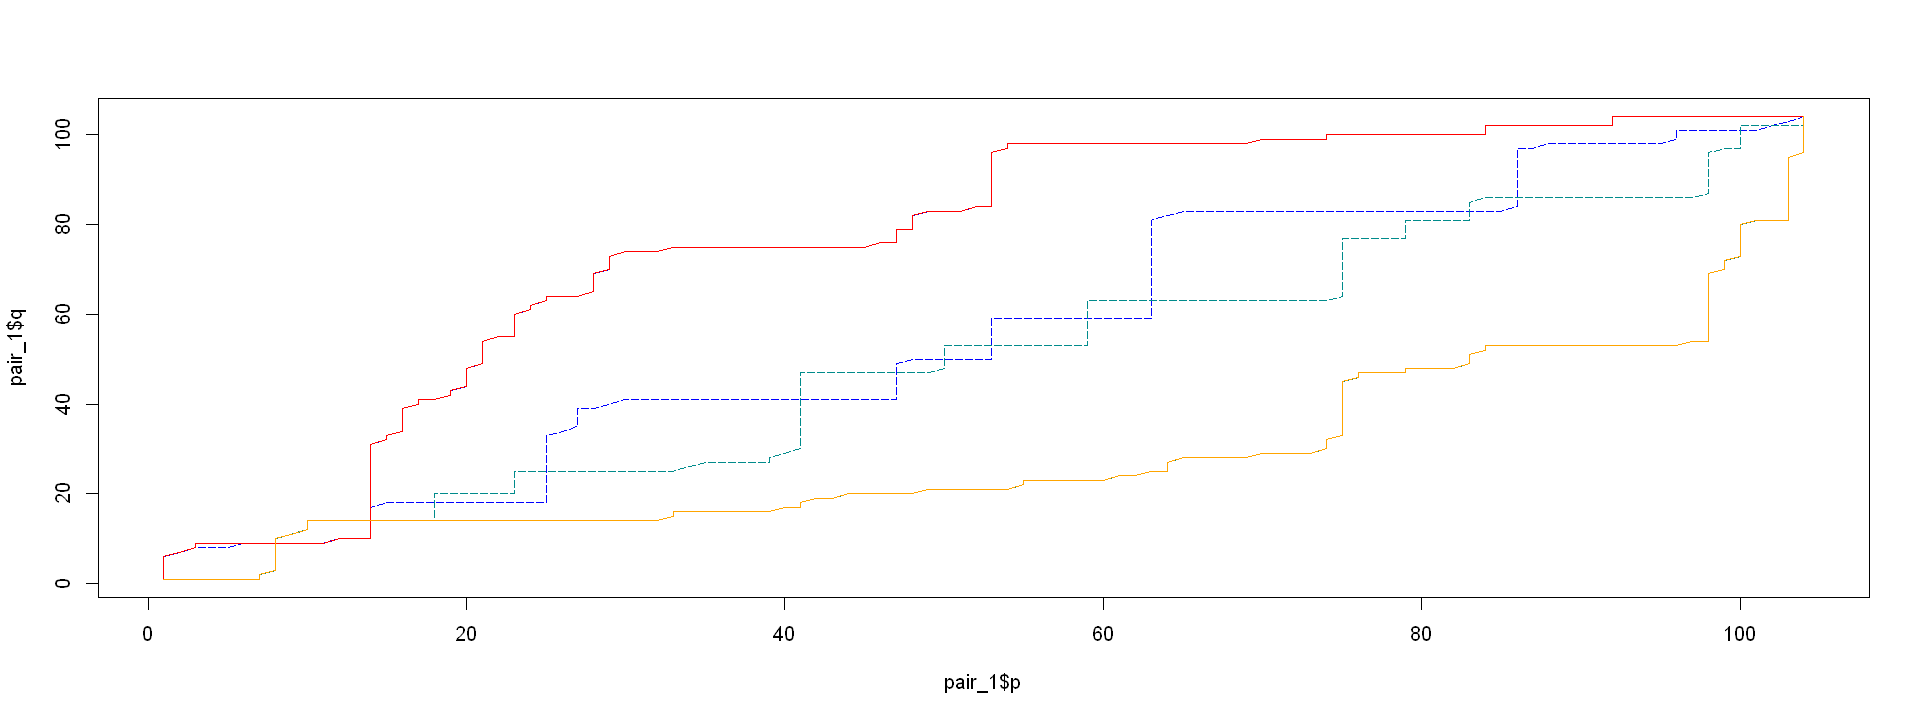

In [15]:
plot(pair_1$p, pair_1$q, col=NULL)
lines(pair_1$p, pair_1$q, col="blue", lty="dotted")
lines(pair_1_wt$p, pair_1_wt$q, col="blue", lty="longdash")
lines(pair_1_dtw$index1, pair_1_dtw$index2, col="red")
lines(pair_2$p, pair_2$q, col="darkcyan", lty="dotted")
lines(pair_2_wt$p, pair_2_wt$q, col="darkcyan", lty="longdash")
lines(pair_2_dtw$index1, pair_2_dtw$index2, col="orange")

In [16]:
set.seed(123)
idx<-seq(0,6.28,len=100);
query<-sin(idx)+runif(100)/10;
## A cosine is for reference; sin and cos are offset by 25 samples
reference<-cos(idx)

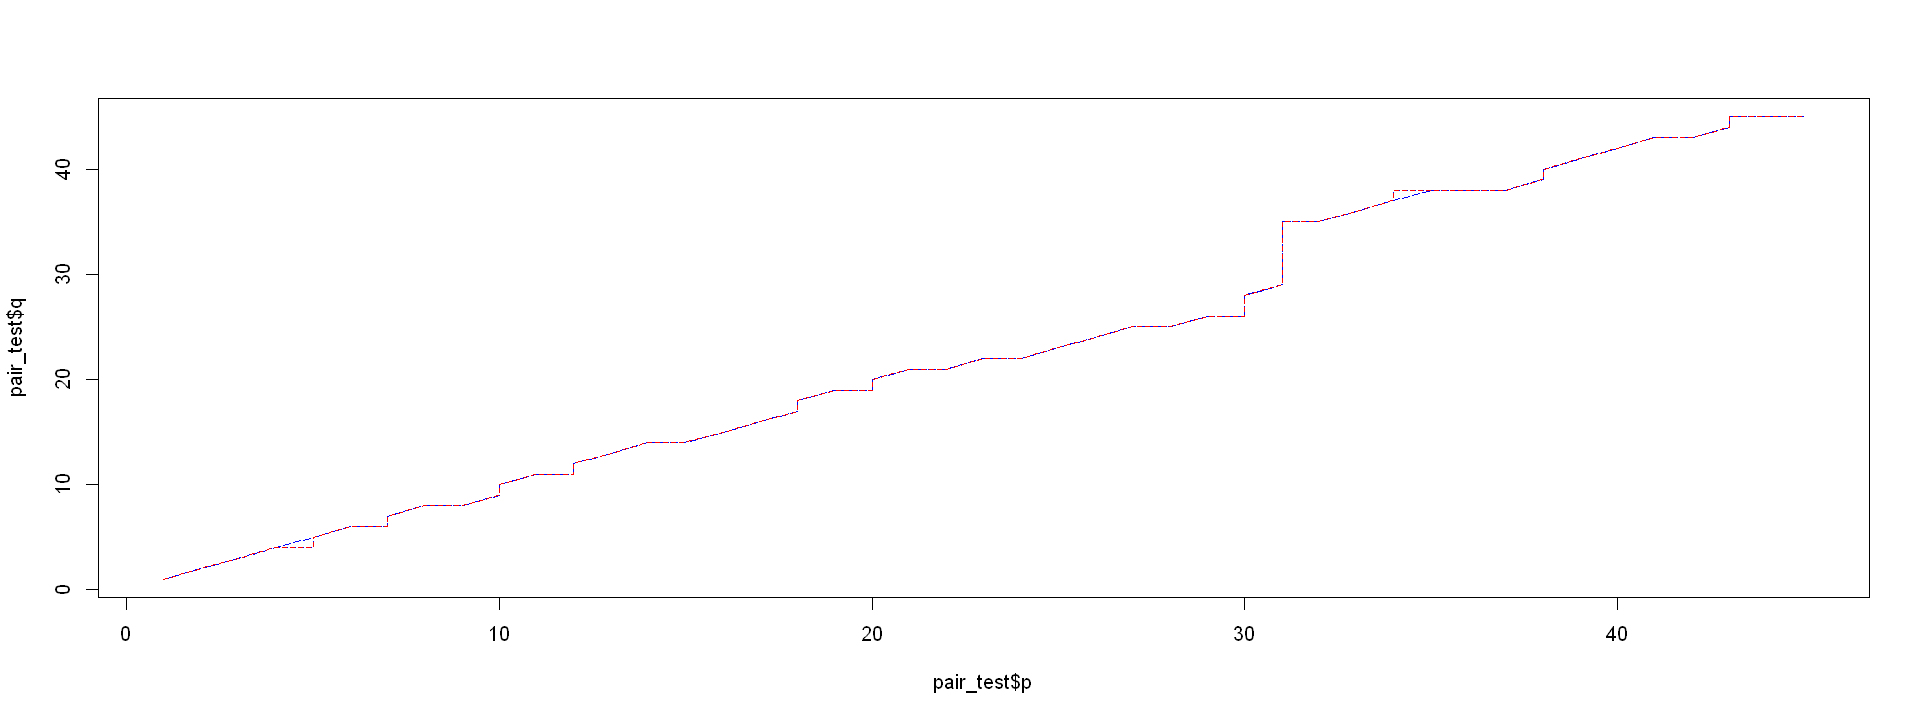

In [17]:
M_test <- dist2_wt(x=as.matrix(query[44:88]), c=as.matrix(reference[19:63]))
M_test_wt <- dist2_wt(x=as.matrix(query[44:88]), c=as.matrix(reference[19:63]), wt_func=weight_fcn)
pair_test <- dpfast(M_test, C=steppattern)
pair_test_wt <- dpfast(M_test_wt, C=steppattern)
pair_test_dtw <- dtw(query[44:88],reference[19:63], keep=TRUE, step=symmetric2);

plot(pair_test$p, pair_test$q, col=NULL)
lines(pair_test$p, pair_test$q, col="blue", lty="dotted")
lines(pair_test_wt$p, pair_test_wt$q, col="blue", lty="longdash")
lines(pair_test_dtw$index1, pair_test_dtw$index2, col="red", lty="dashed")

### Consistent Pairing Results Compared to `dtw`

In [18]:
# results are the same if 0, otherwise non-zero
sum(pair_test$p != pair_test_dtw$index1) + sum(pair_test$q != pair_test_dtw$index2)

[1] 0

### Inconsistent Distance Results

In [19]:
pair_test_dtw$distance

[1] 1.354508

In [20]:
pair_test_dtw$normalizedDistance

[1] 0.01505009

In [21]:
# distance is different?
sum(pair_test$sc)

[1] 1.109464

## Plot

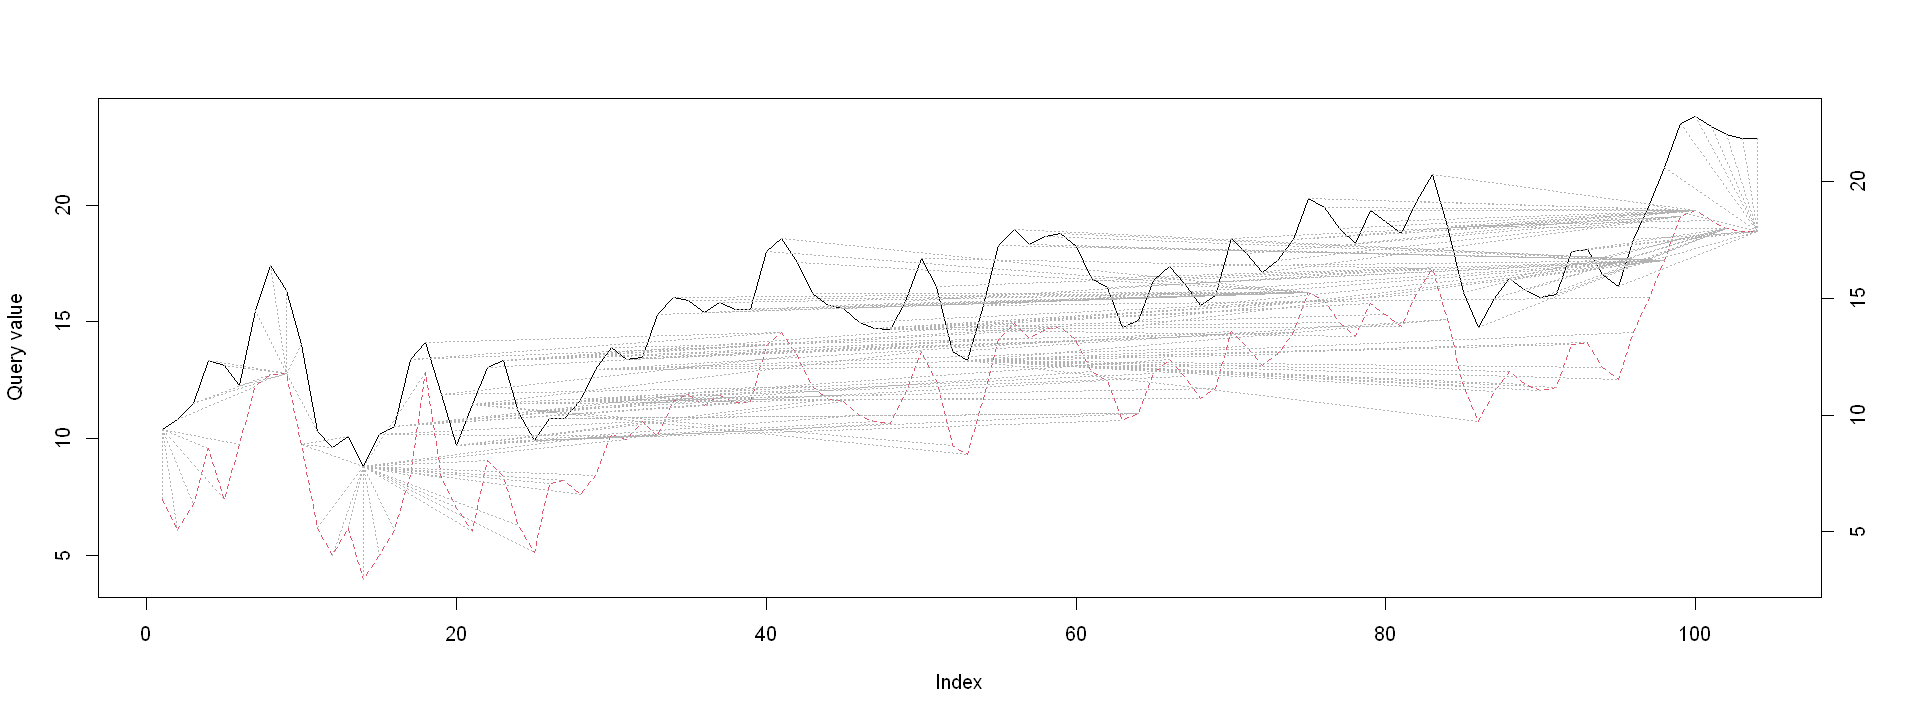

In [22]:
plot(pair_1_dtw, type="two", off=1);

In [23]:
plot_fcn <- function(xts, yts, pair_obj, offset=1) {
    ## Save default for resetting
    def.par <- par(no.readonly = TRUE)
    
    ## Make room for secondary axis, if any
    if(offset!=0) {
        par(mar=c(5,4,4,4)+.1)
    }
    
    ytso <- yts + offset
    matplot(cbind(xts, ytso), type="l", pch=21)
    
    box()
    axis(1)
    axis(2,at=pretty(xts))
    
    ## Display secondary axis if offset
    if(offset!=0) {
        rightTicks <- pretty(yts)
        axis(4,at=rightTicks+offset,labels=rightTicks)
    }

    ml<-length(pair_obj$p)
    idx<-1:ml
    
    ## x0, y0 coordinates of points from which to draw.
    ## x1, y1 coordinates of points to which to draw.
    segments(pair_obj$p[idx], xts[pair_obj$p[idx]],  # from
             pair_obj$q[idx], ytso[pair_obj$q[idx]], # to
             col="gray70", lty=3)
    
    # Reset to default
    par(def.par)
}

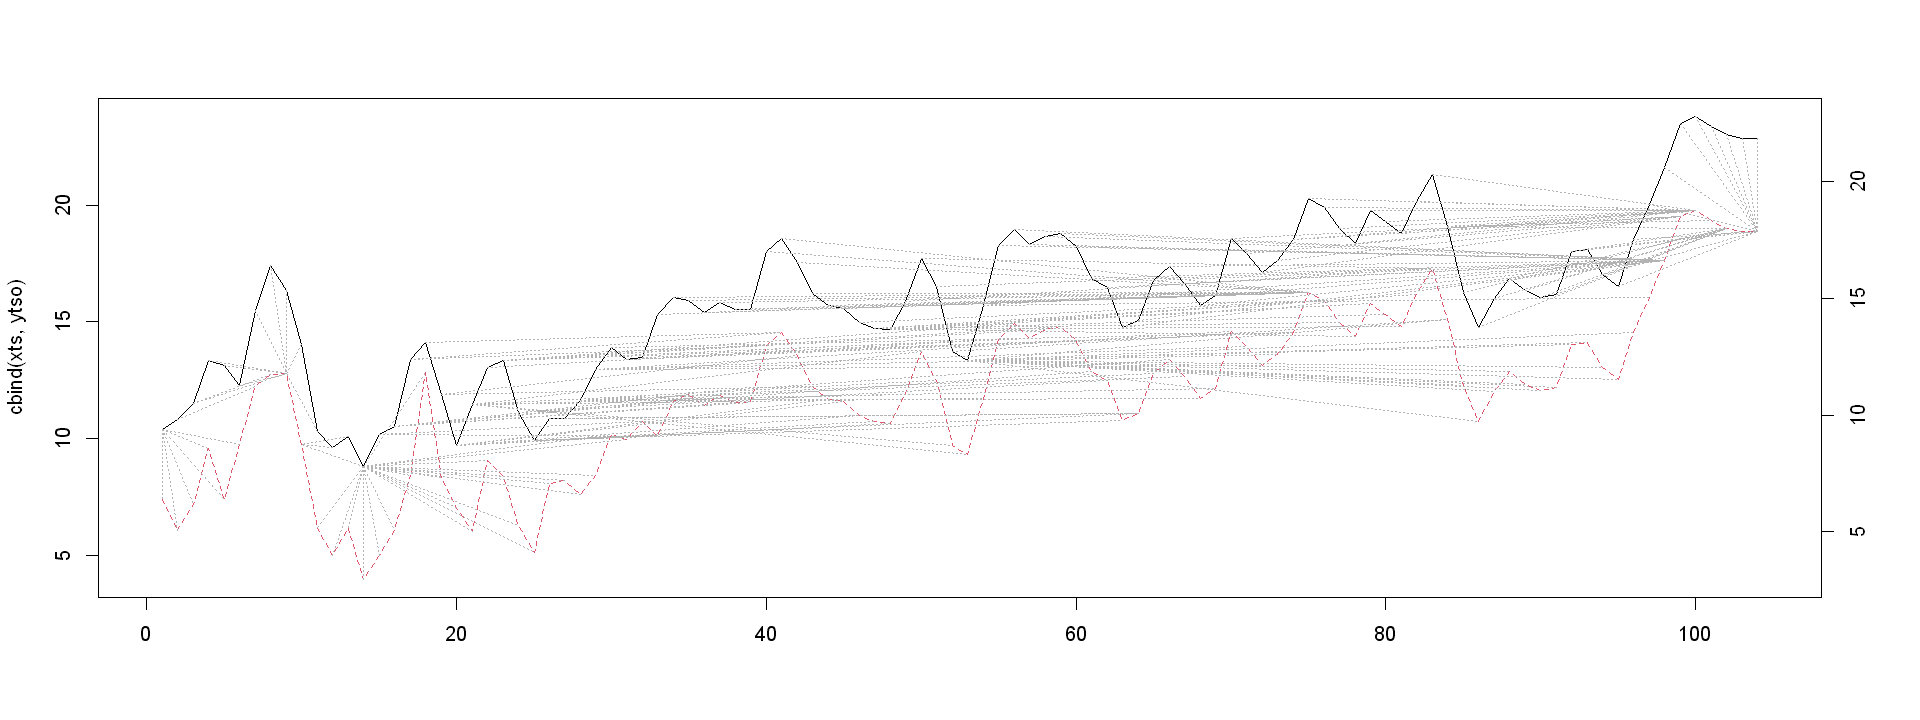

In [24]:
plot_fcn(seq_ref, seq_q1, pair_1)

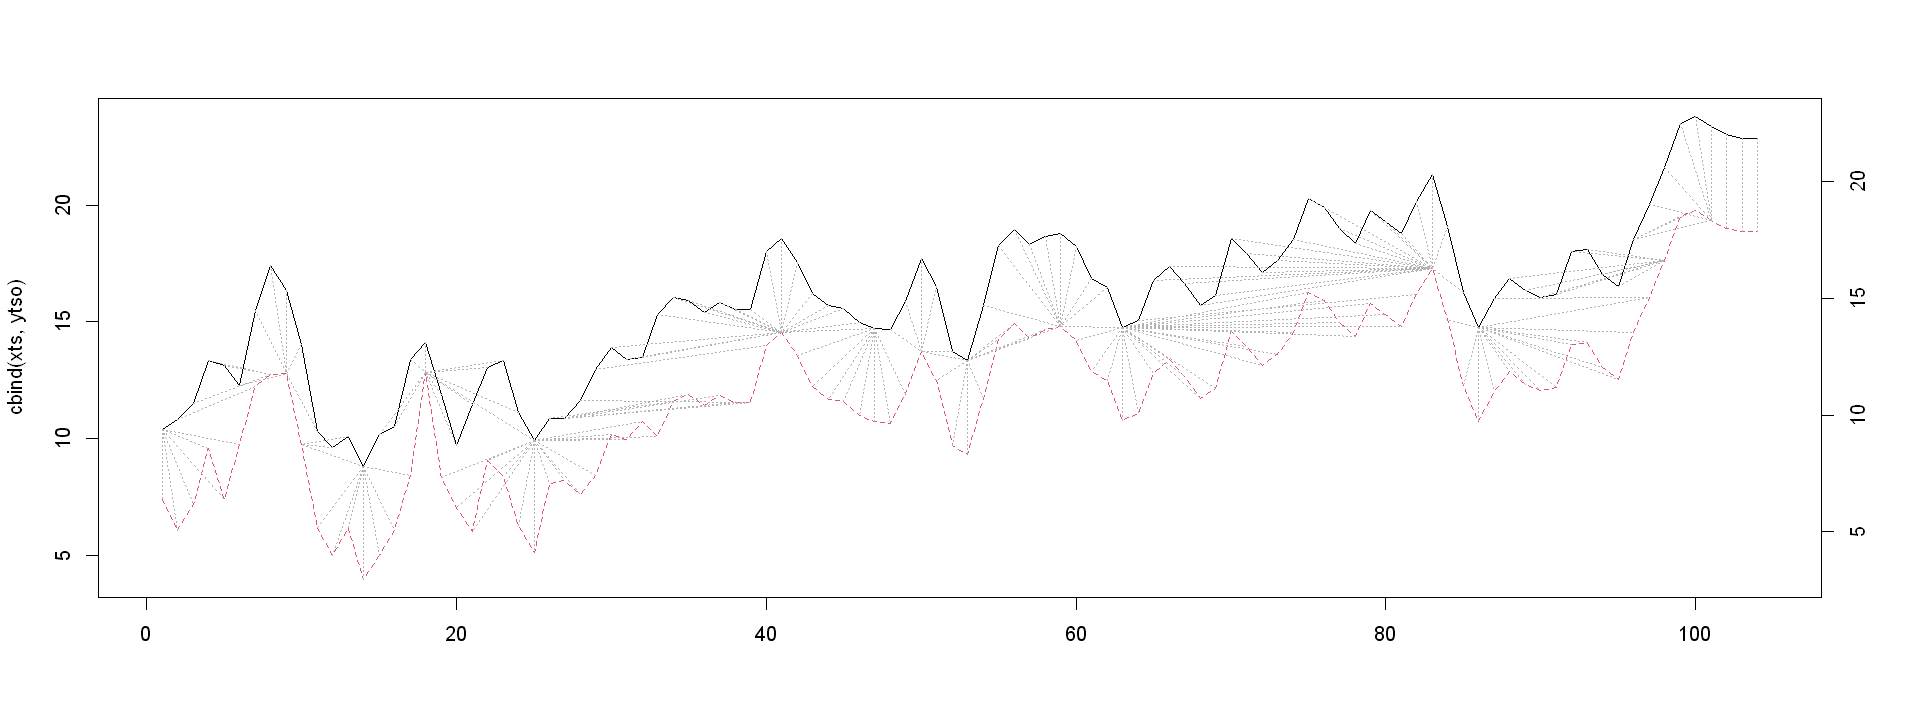

In [25]:
plot_fcn(seq_ref, seq_q1, pair_1_wt)

In [26]:
cbind(pair_1_wt$p, pair_1_wt$q)

1,1
1,2
1,3
1,4
1,5
1,6
2,7
3,8
4,8
5,8
6,9


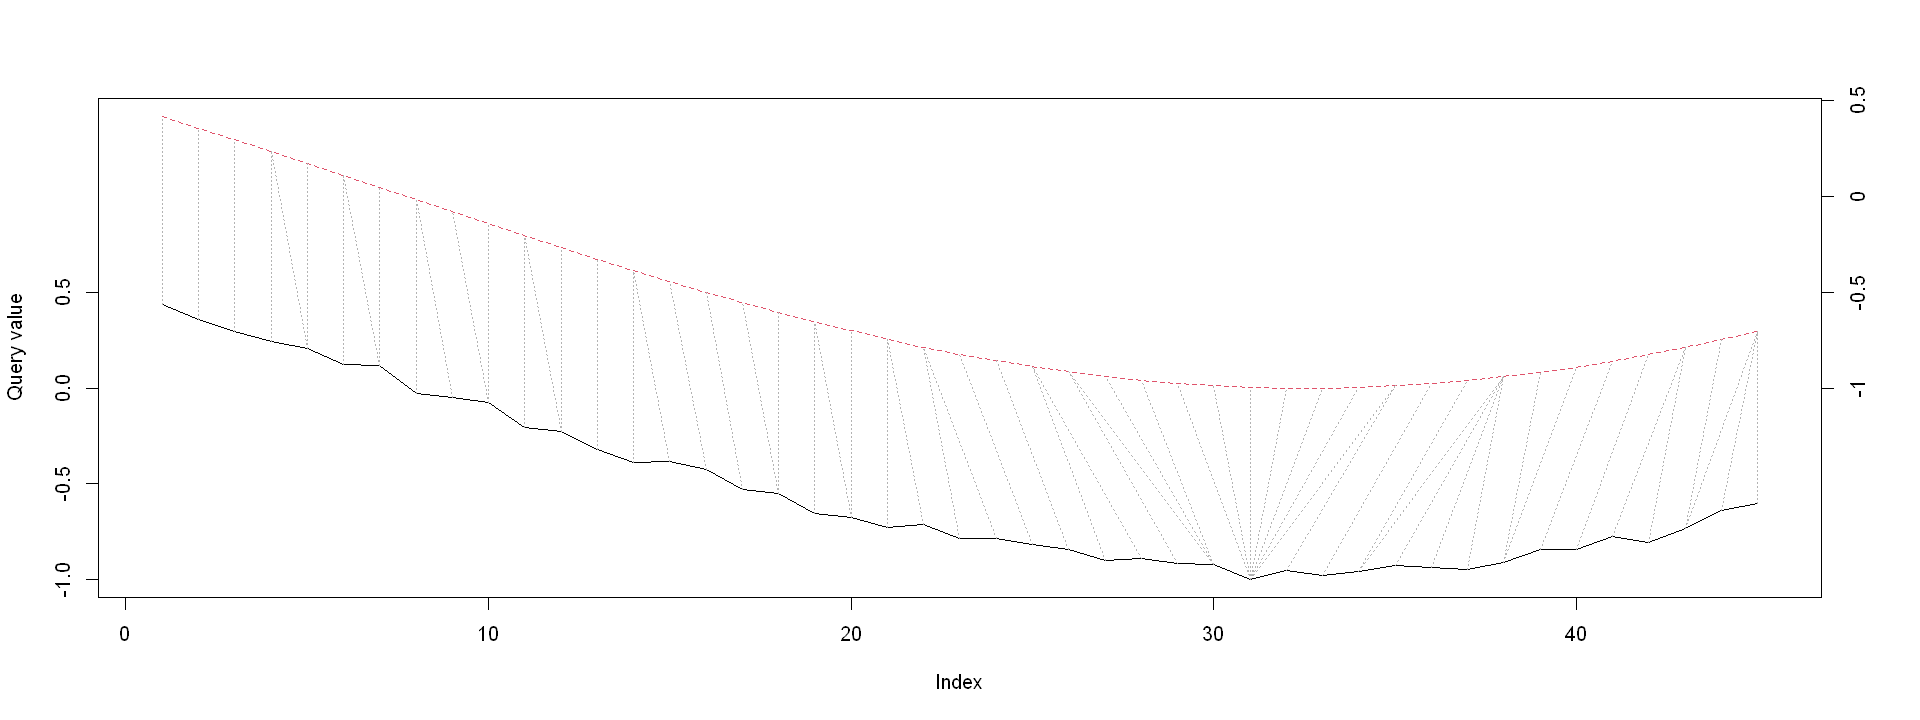

In [27]:
plot(pair_test_dtw, type="two", off=1);

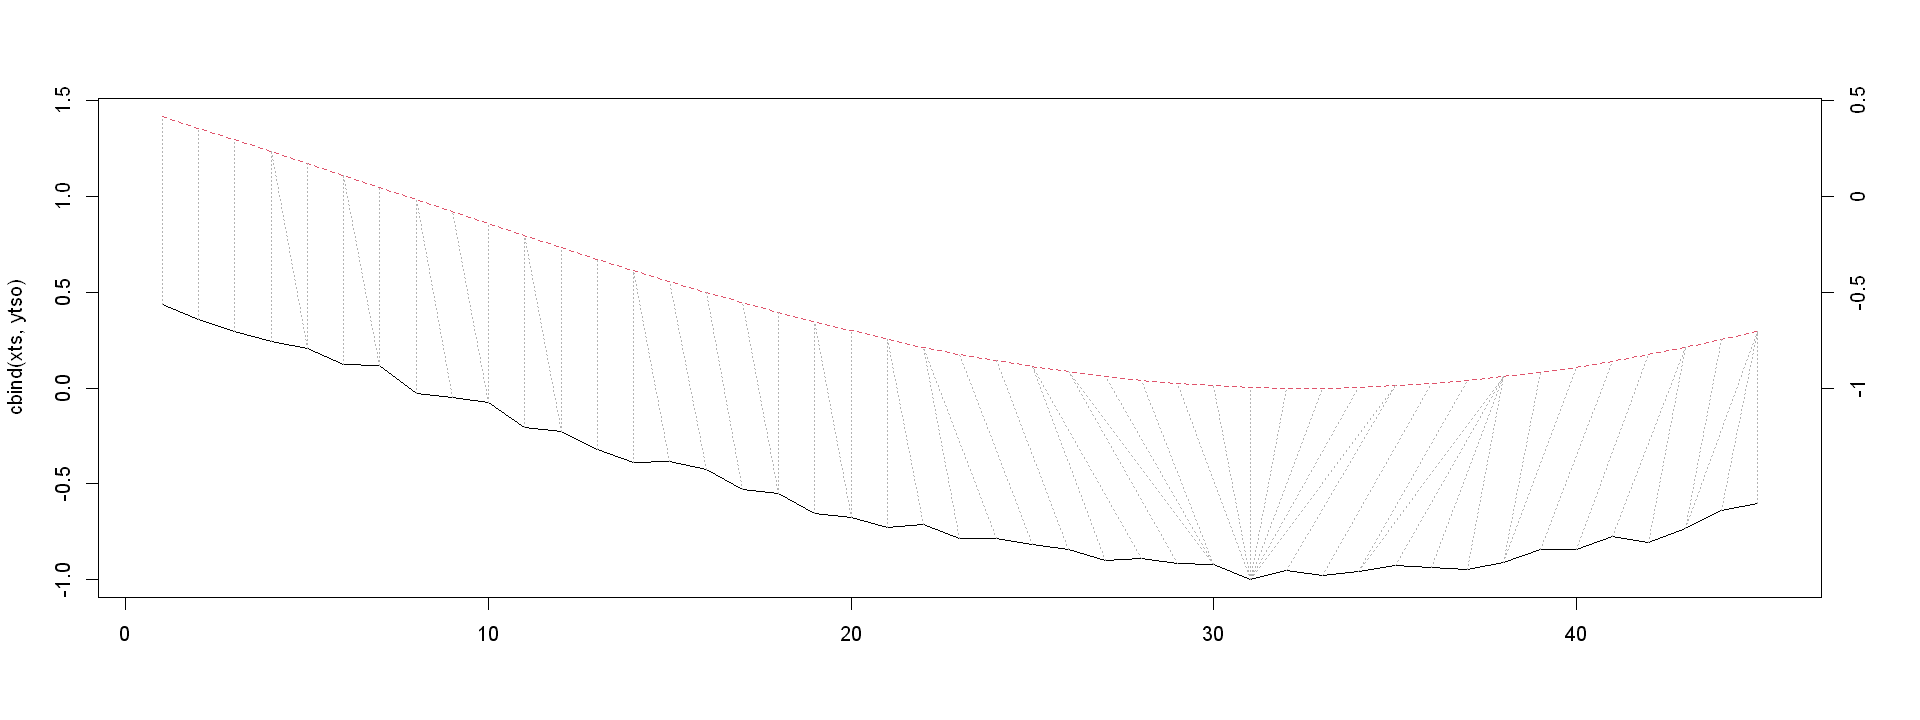

In [28]:
plot_fcn(pair_test_dtw$query, pair_test_dtw$reference, pair_test)

https://statisticsglobe.com/add-line-segment-curve-ggplot2-plot-r

## Window Type

+ "sakoechiba" A band around main diagonal

+ "slantedband" A band around slanted diagonal

+ "itakura" So-called Itakura parallelogram

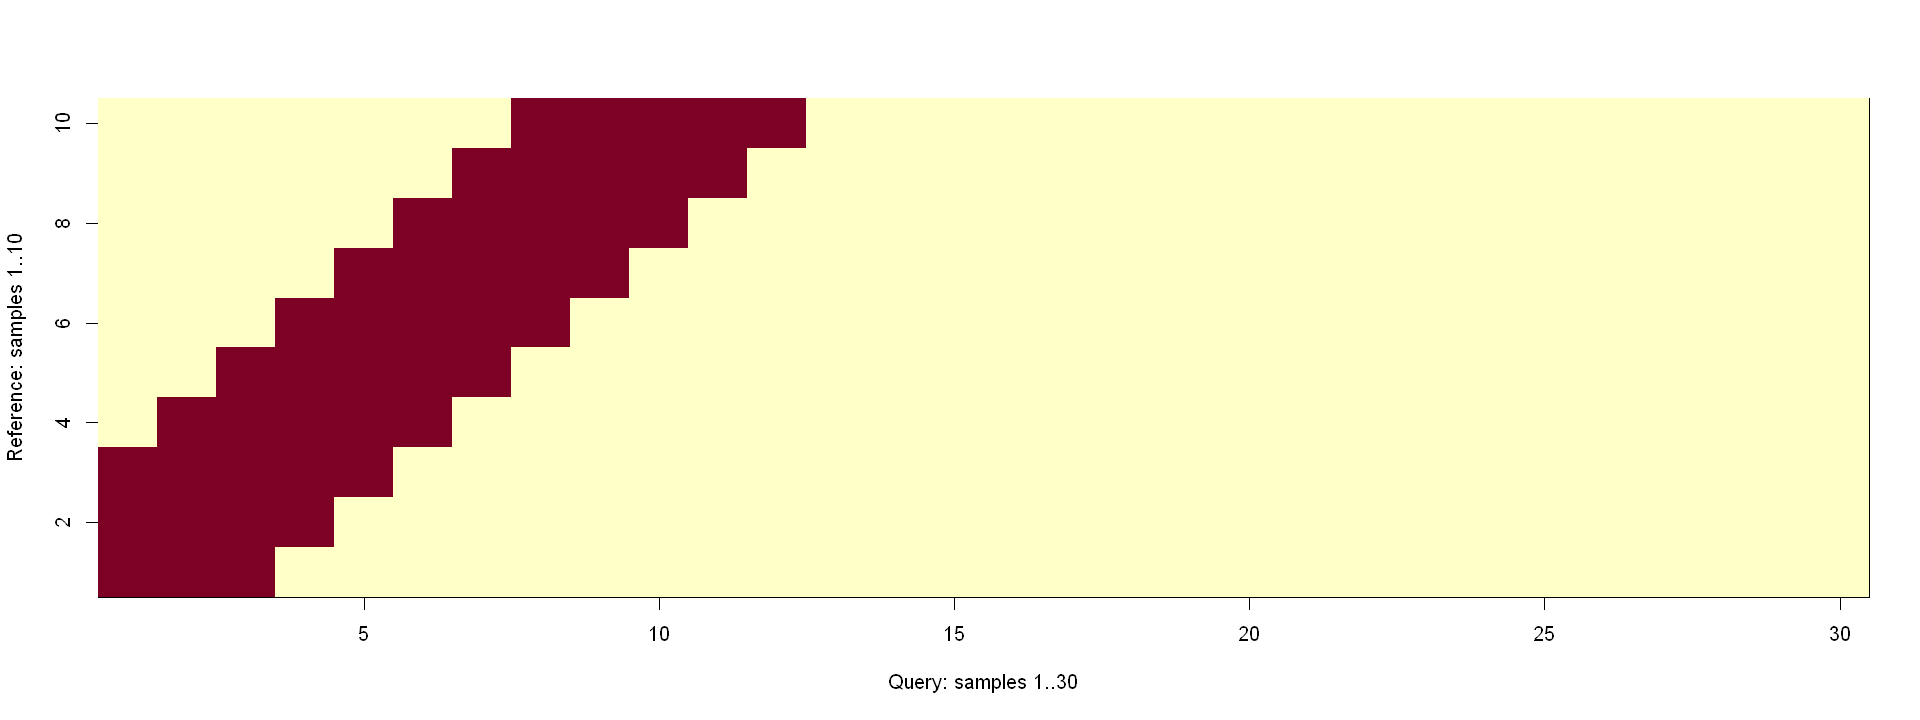

In [29]:
dtwWindow.plot(sakoeChibaWindow, window.size = 2, ref=10, query=30)

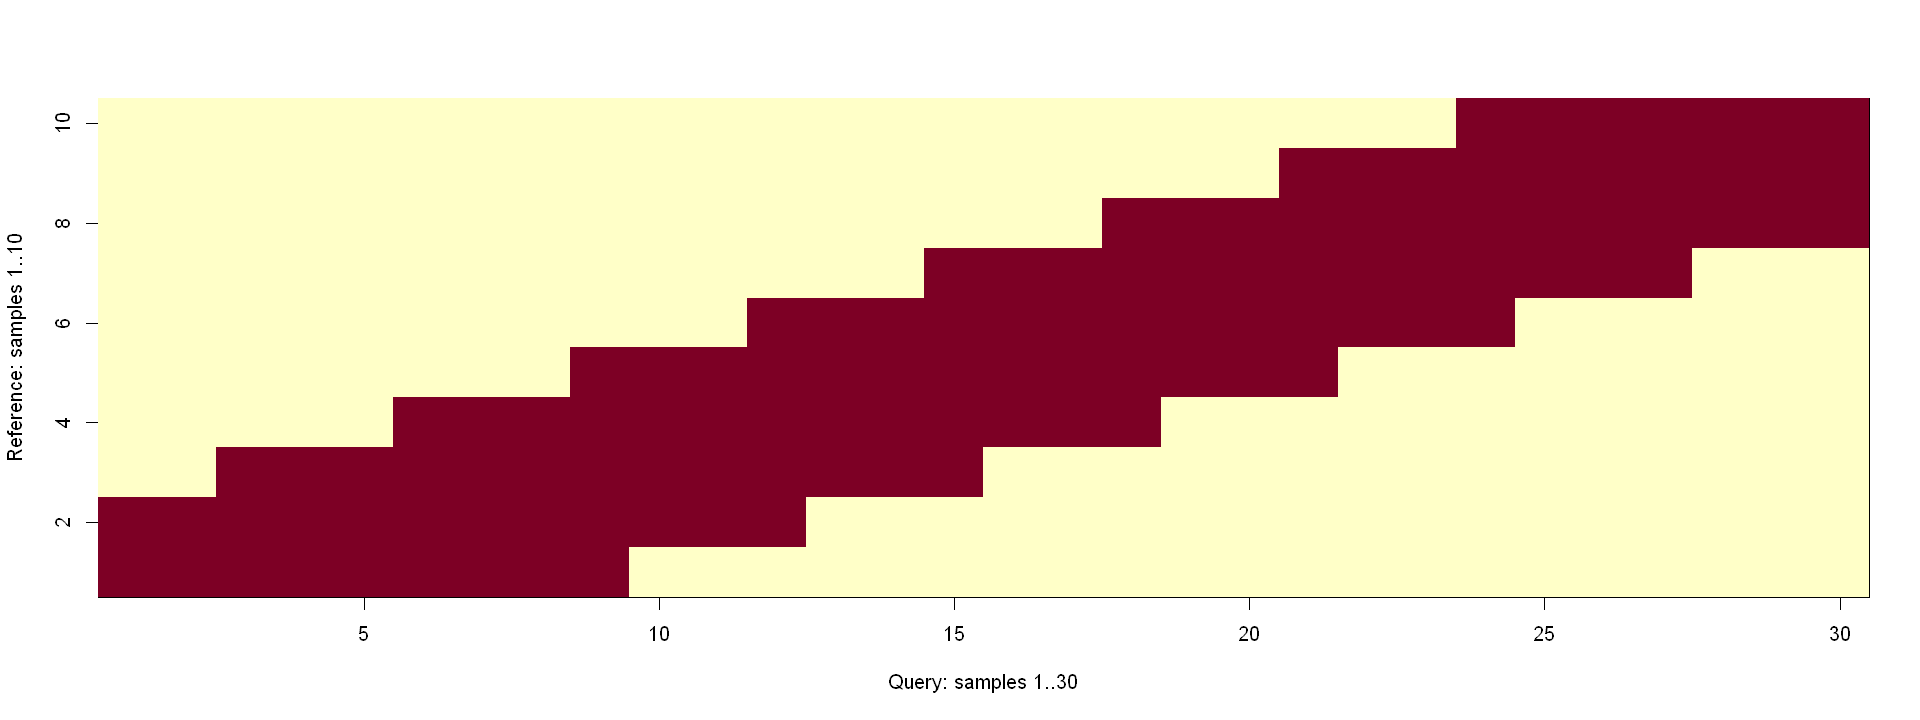

In [30]:
dtwWindow.plot(slantedBandWindow, window.size = 2, ref=10, query=30)

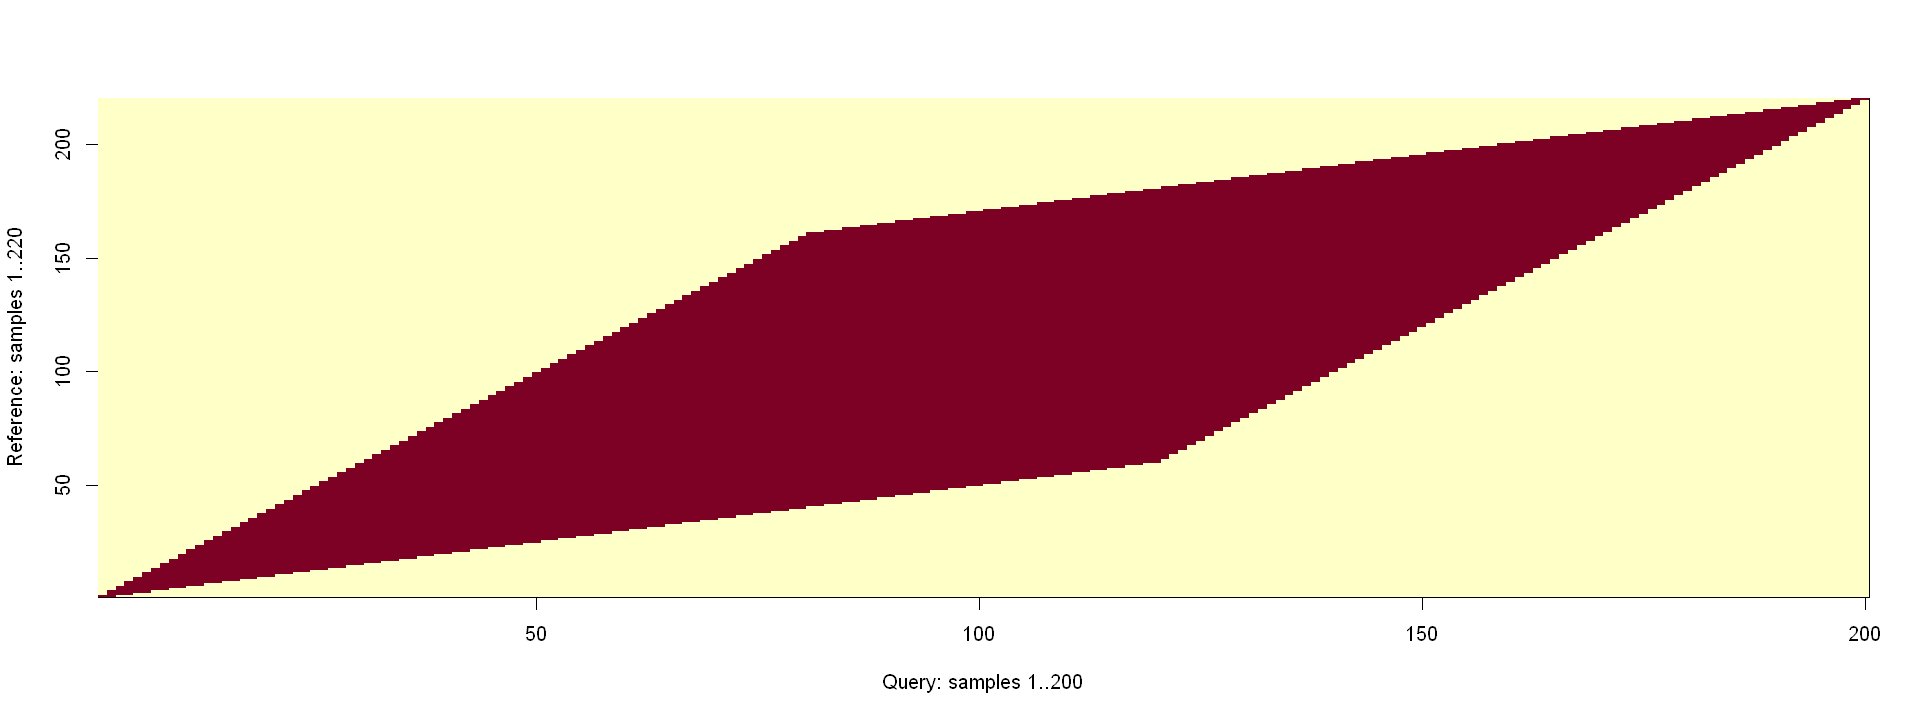

In [31]:
dtwWindow.plot(itakuraWindow)

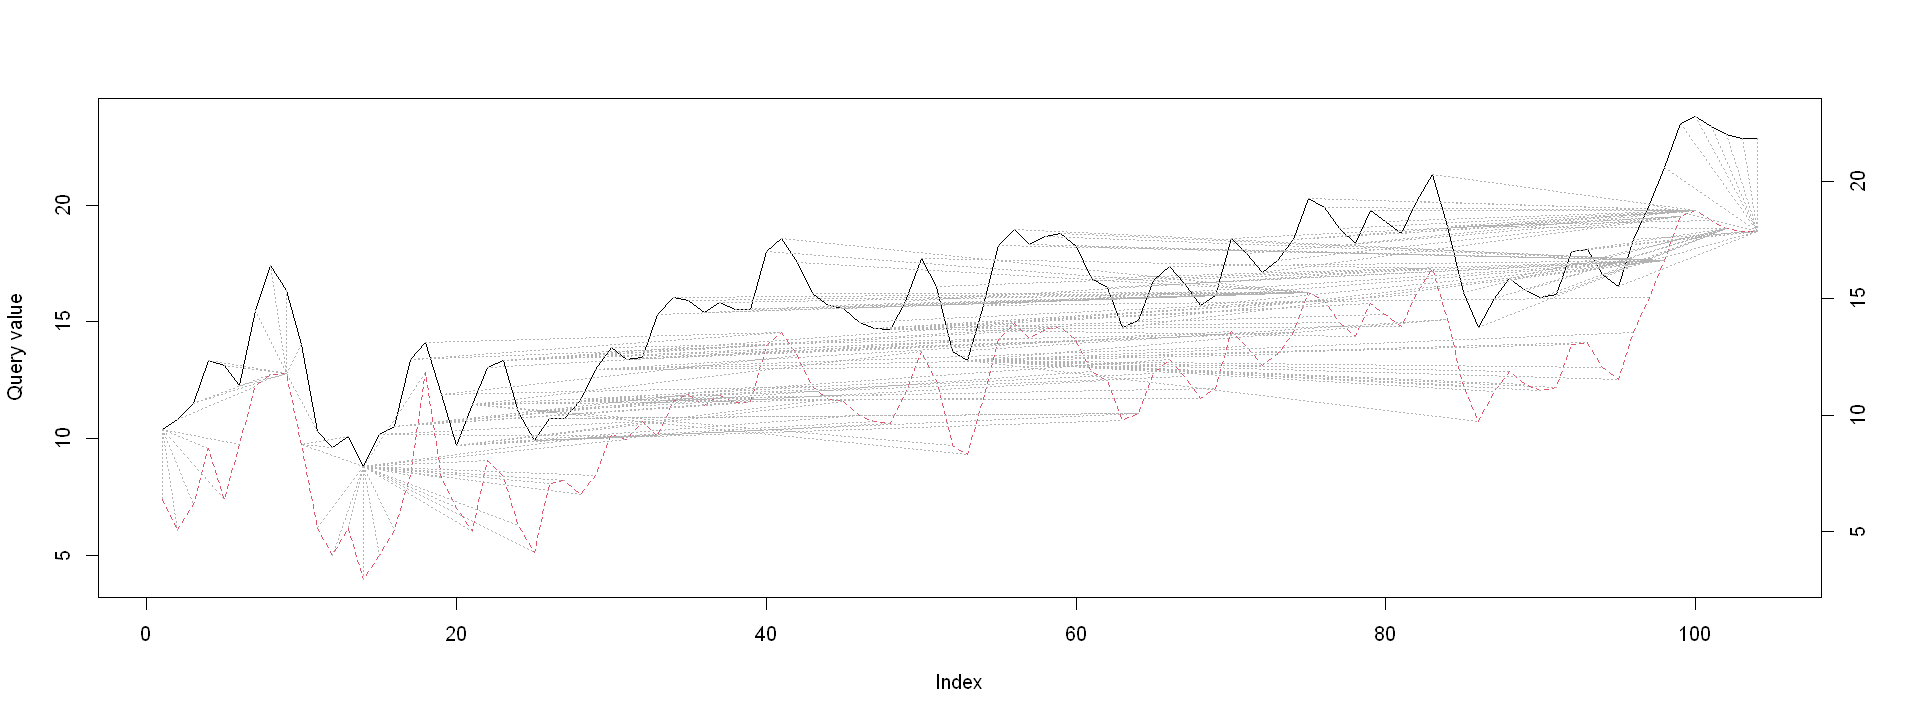

In [32]:
plot(pair_1_dtw, type="two", off=1)

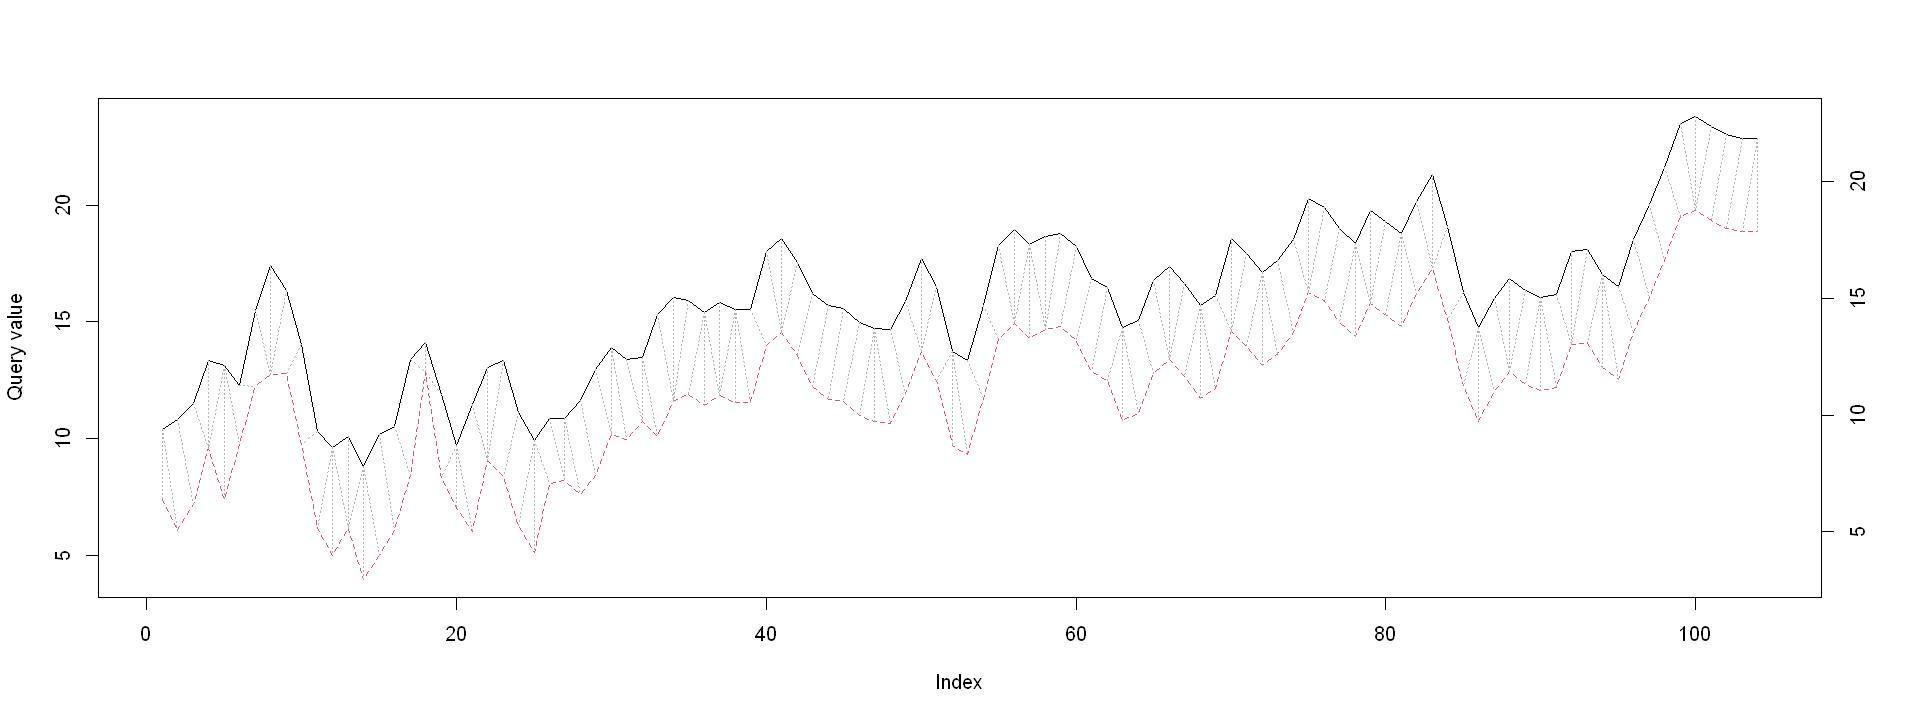

In [33]:
pair_1_dtw_window1 <- dtw(x=seq_ref, y=seq_q1, keep=TRUE, 
                         window.type=sakoeChibaWindow, window.size=1)
plot(pair_1_dtw_window1, type="two", off=1)

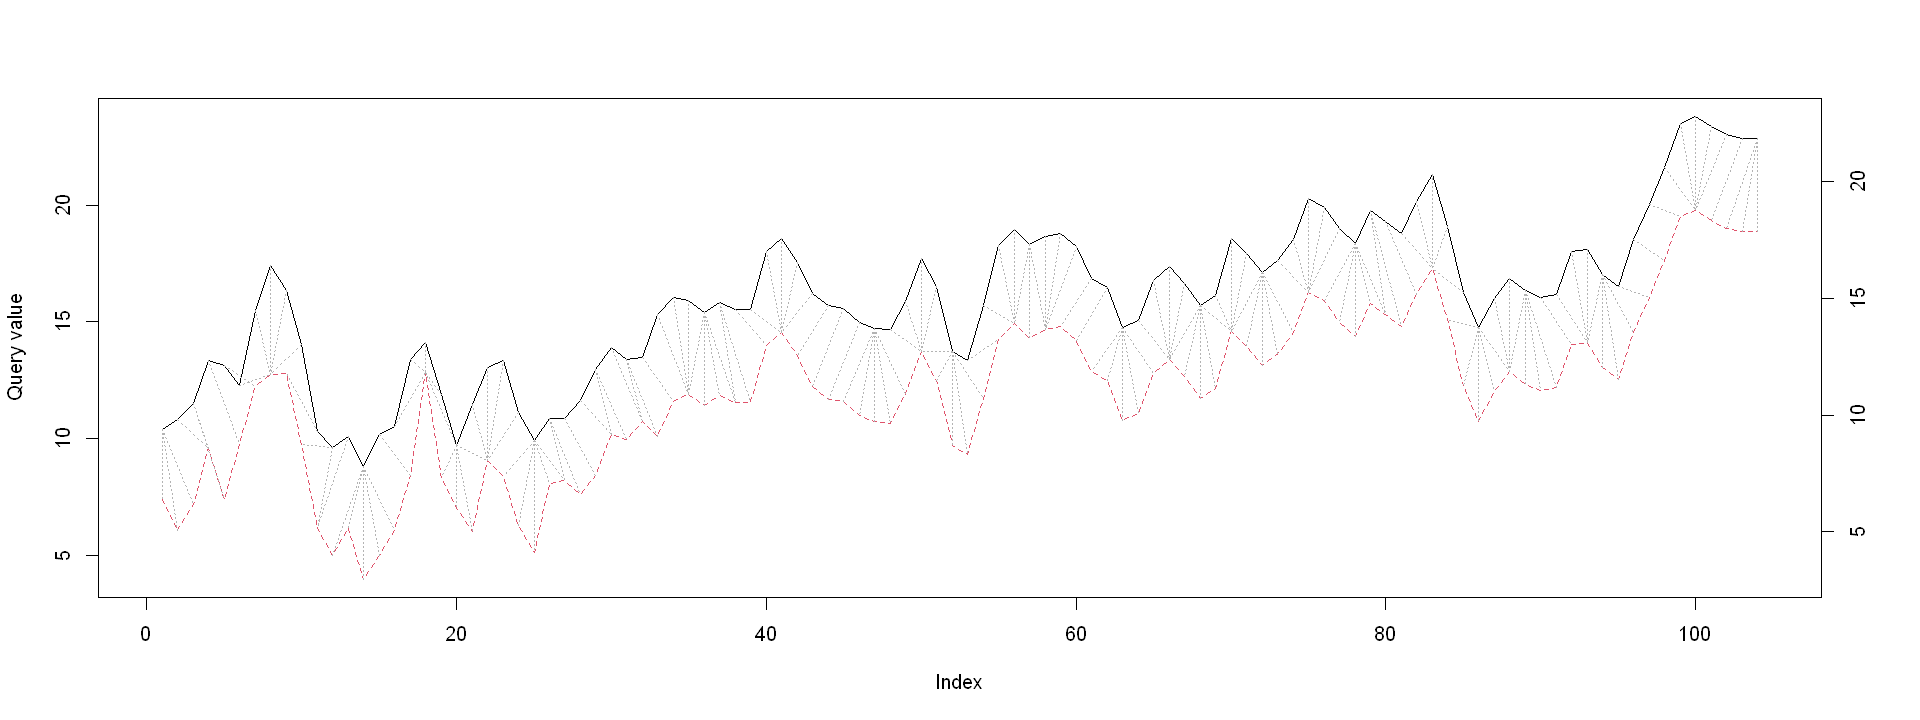

In [34]:
pair_1_dtw_window2 <- dtw(x=seq_ref, y=seq_q1, keep=TRUE, 
                         window.type=sakoeChibaWindow, window.size=2)
plot(pair_1_dtw_window2, type="two", off=1)

In [35]:
print(pair_1_dtw$distance)
print(pair_1_dtw$normalizedDistance)
print(pair_1_dtw_window1$distance)
print(pair_1_dtw_window1$normalizedDistance)
print(pair_1_dtw_window2$distance)
print(pair_1_dtw_window2$normalizedDistance)

[1] 263.7784
[1] 1.268165
[1] 845.1639
[1] 4.063288
[1] 745.2638
[1] 3.582999


In [36]:
window_fcn <- function(mat, window_size) {
    # mat <- M_1
    n_col <- ncol(mat)
    n_row <- nrow(mat)
    
    id_matrix <- matrix(0, ncol=n_col, nrow=n_row)
    ws <- window_size
    for (j in 1:n_col) {
        i <- n_row - j + 1
        i_list <- c((i-ws):(i+ws))
        i_sel <- i_list[(i_list > 0) & (i_list <= n_row)]
        id_matrix[i_sel, j] <- 1
    }
    mat_ws <- id_matrix * mat
    mat_ws[mat_ws==0] <- 999999999999999999999999999 # tricky to find a number represent Inf # max(mat_ws)*2 # Inf #
    return(mat_ws)
}

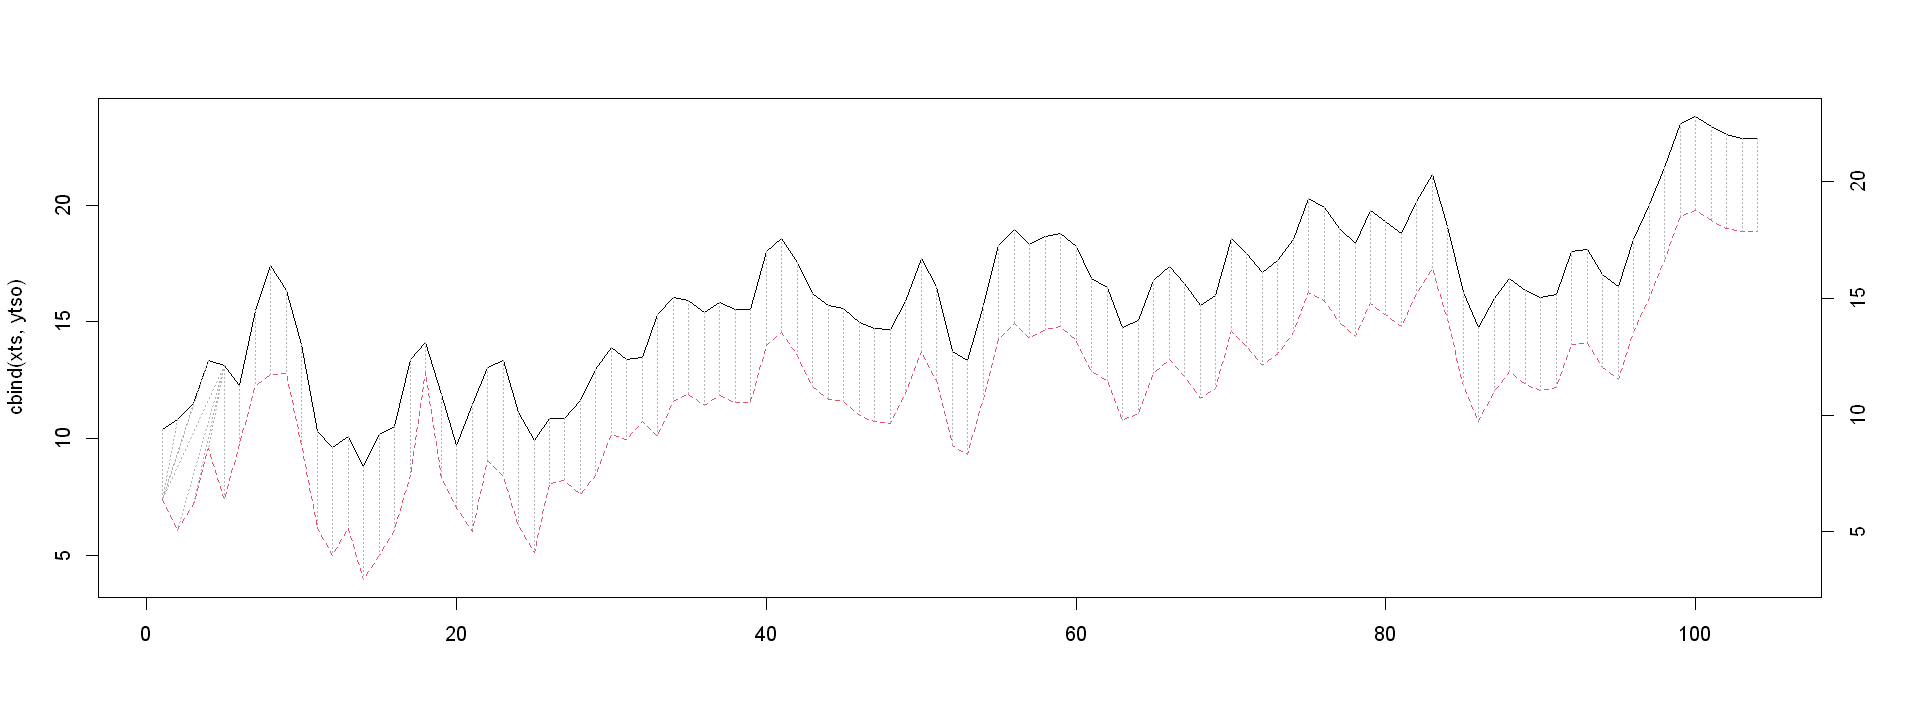

In [37]:
M_1_ws1 <- window_fcn(mat=M_1, window_size=1)
pair_1_ws1 <- dpfast(M_1_ws1, C=steppattern)
plot_fcn(seq_ref, seq_q1, pair_1_ws1)

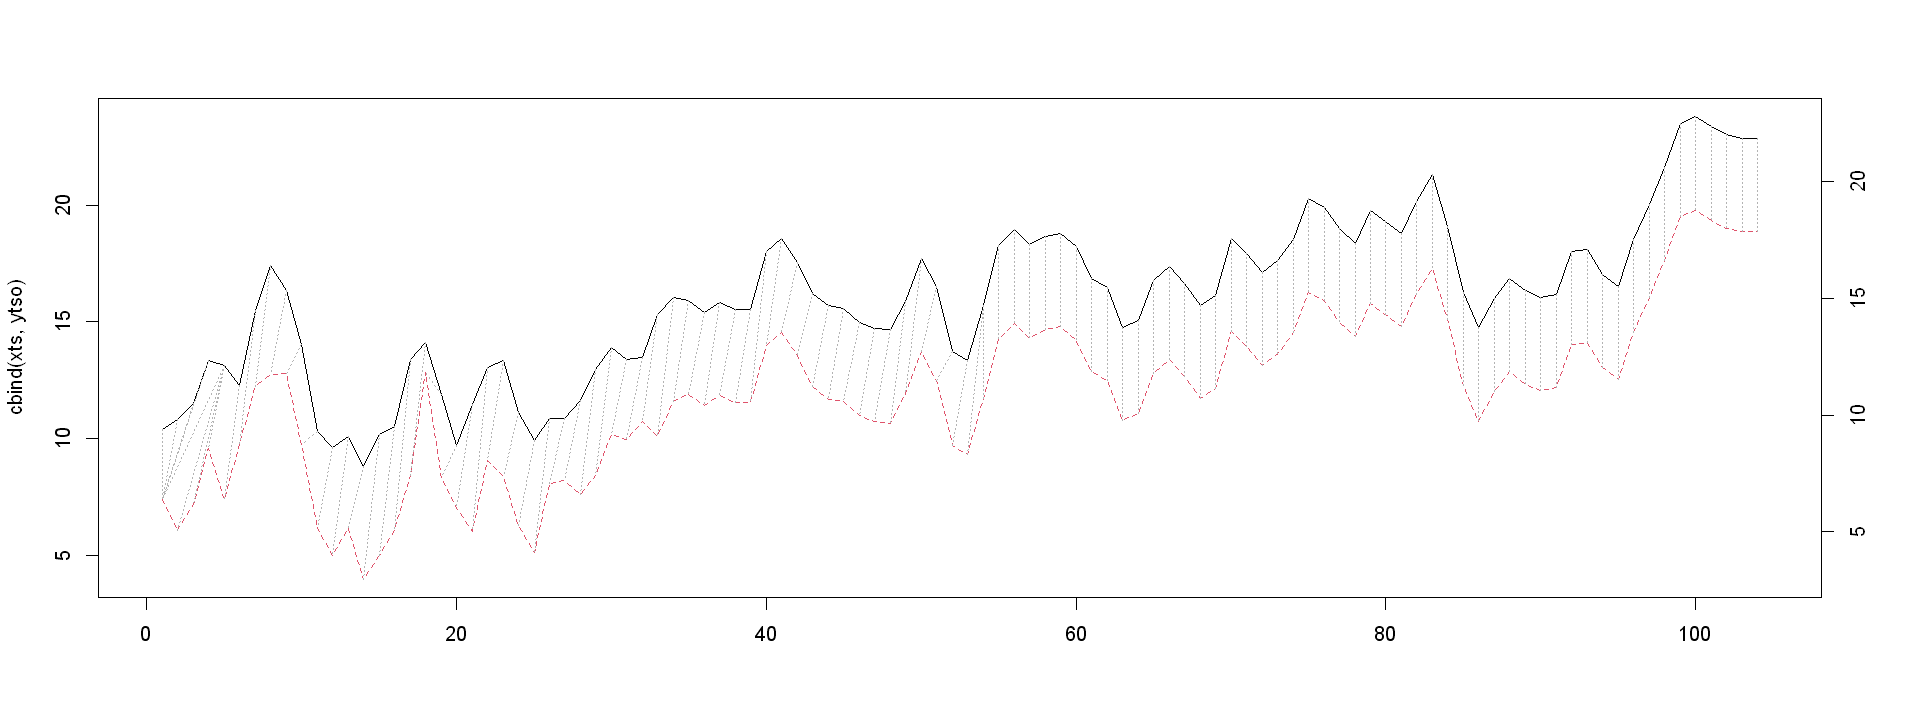

In [38]:
M_1_ws2 <- window_fcn(mat=M_1, window_size=2)
pair_1_ws2 <- dpfast(M_1_ws2, C=steppattern)
plot_fcn(seq_ref, seq_q1, pair_1_ws2)

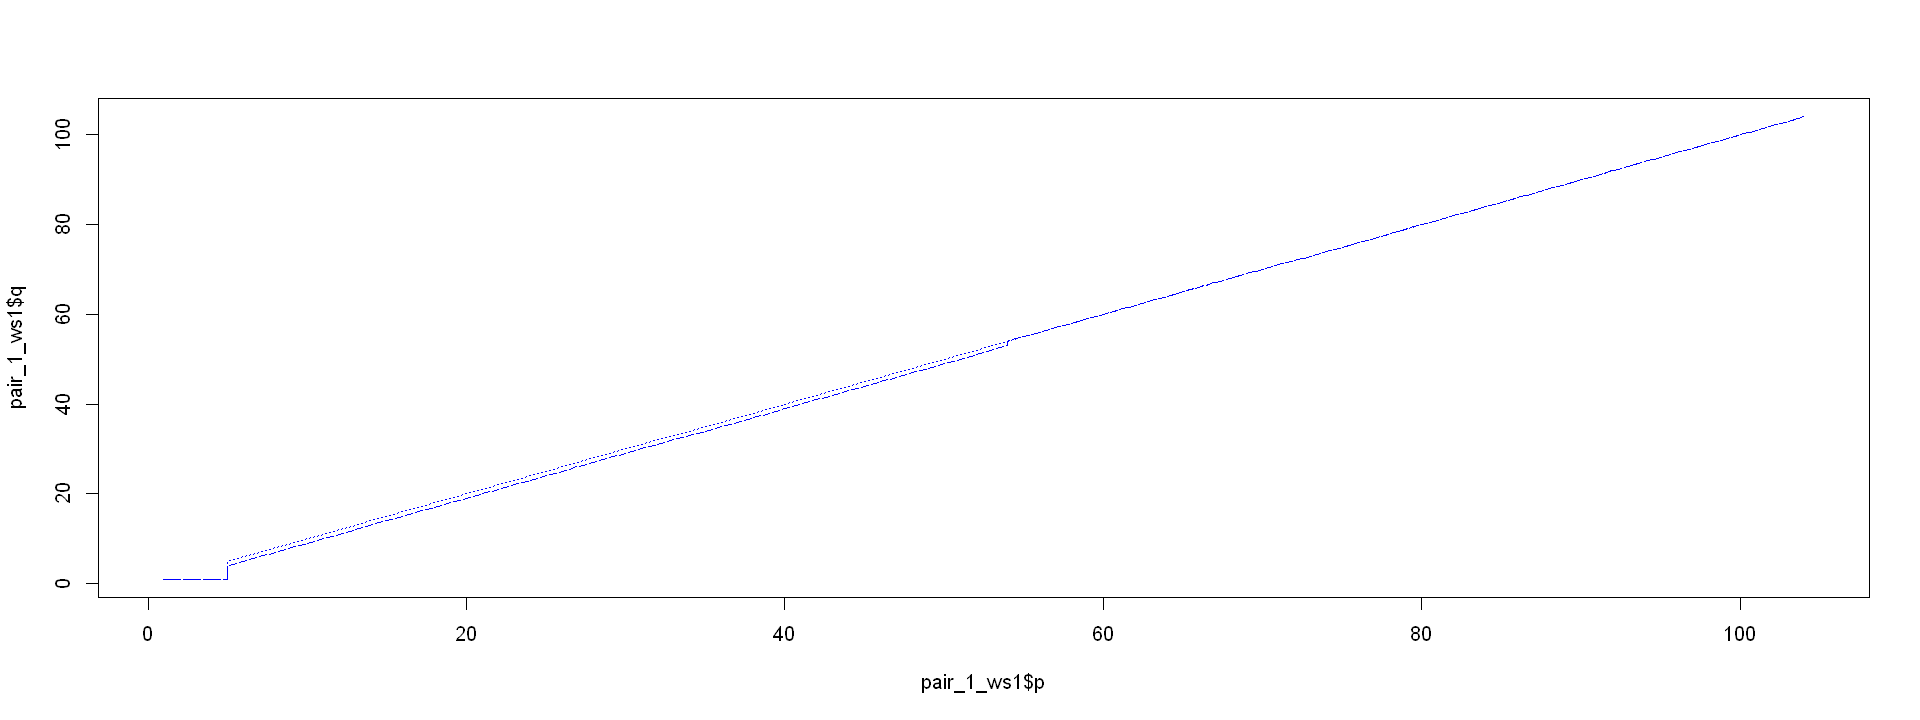

In [39]:
plot(pair_1_ws1$p, pair_1_ws1$q, col=NULL)
lines(pair_1_ws1$p, pair_1_ws1$q, col="blue", lty="dotted")
lines(pair_1_ws2$p, pair_1_ws2$q, col="blue", lty="longdash")

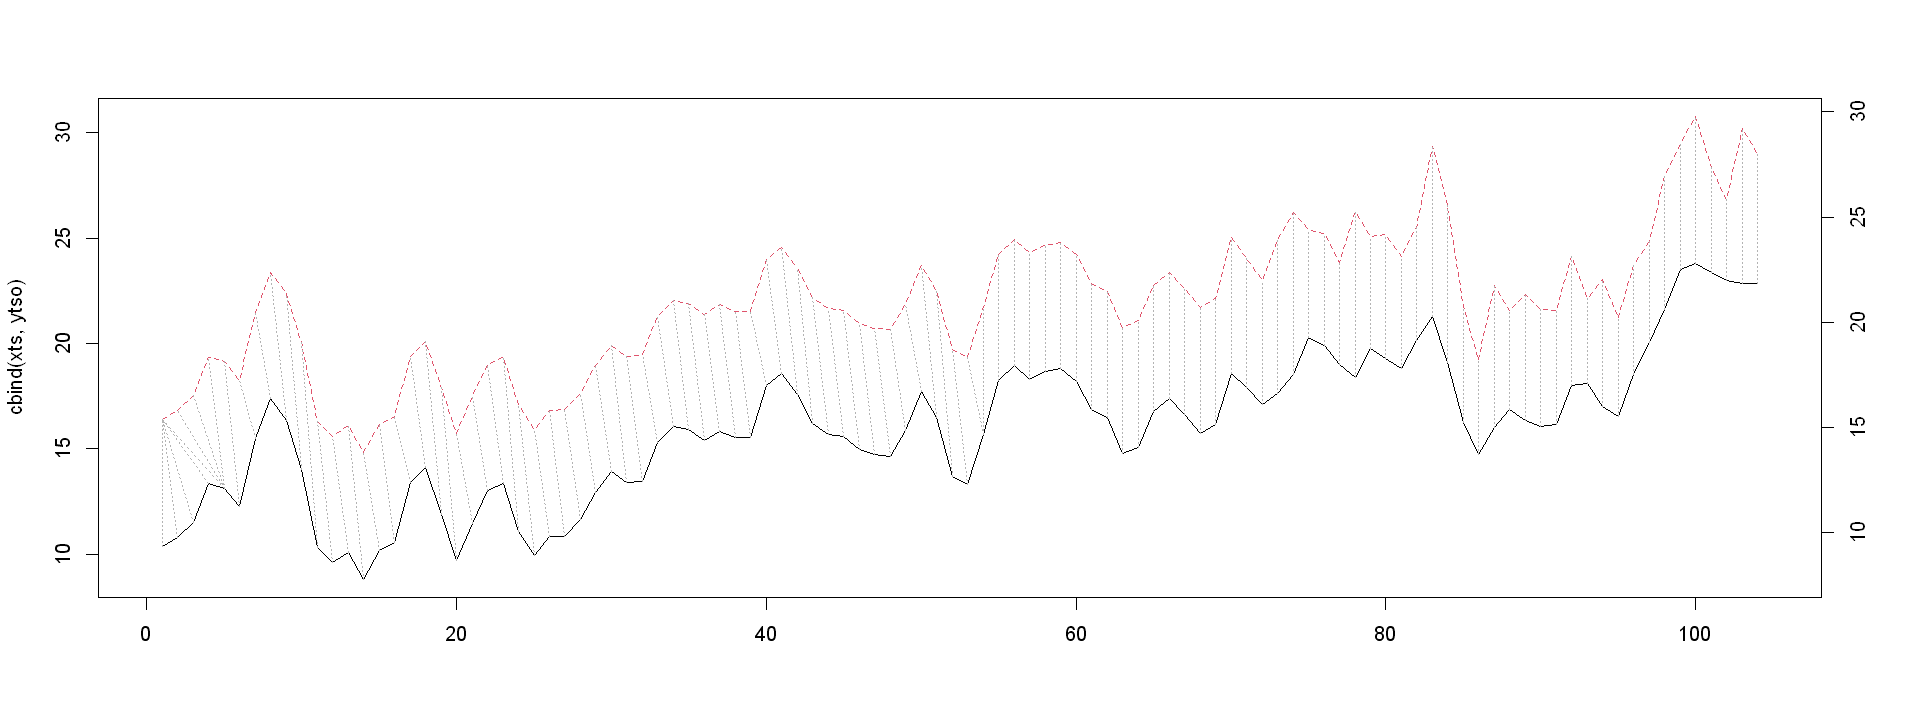

In [40]:
M_2_wt_ws2 <- window_fcn(M_2_wt, window_size=2)
pair_2_wt_ws2 <- dpfast(M_2_wt_ws2, C=steppattern)
plot_fcn(seq_ref, seq_q2, pair_2_wt_ws2)

## Appendix

### Harmonic Mean for Two Types of Weights (Bad!!!)

This is not a good idea to combine two types of weights using harmonic mean. The harmonic mean shows non-monotonic trend, which is bad as a weight metric.

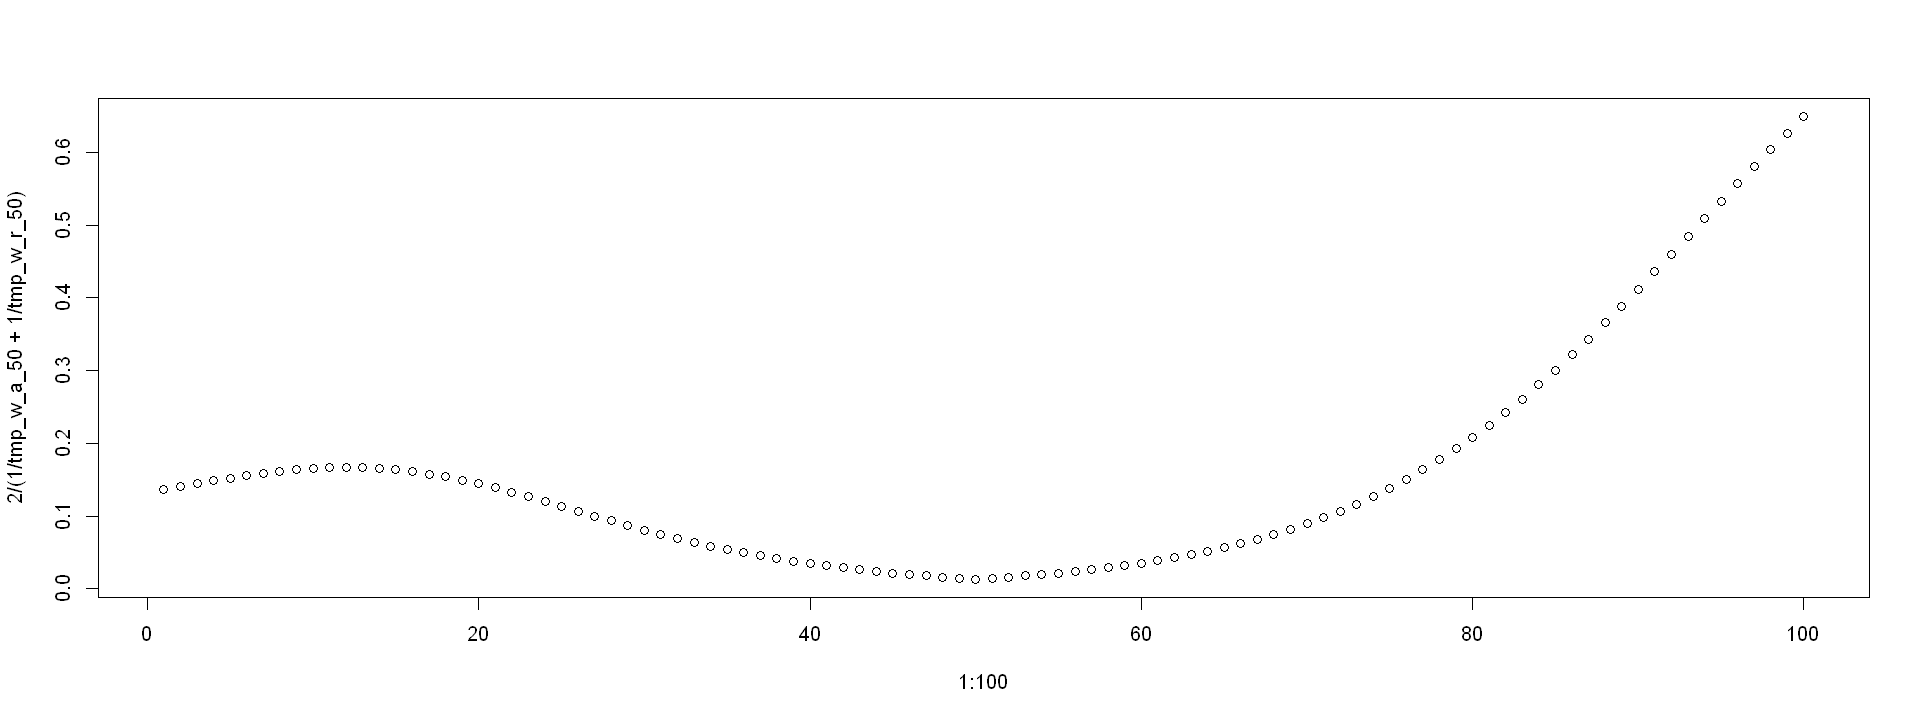

In [10]:
plot(1:100, 2/(1/tmp_w_a_50+1/tmp_w_r_50))

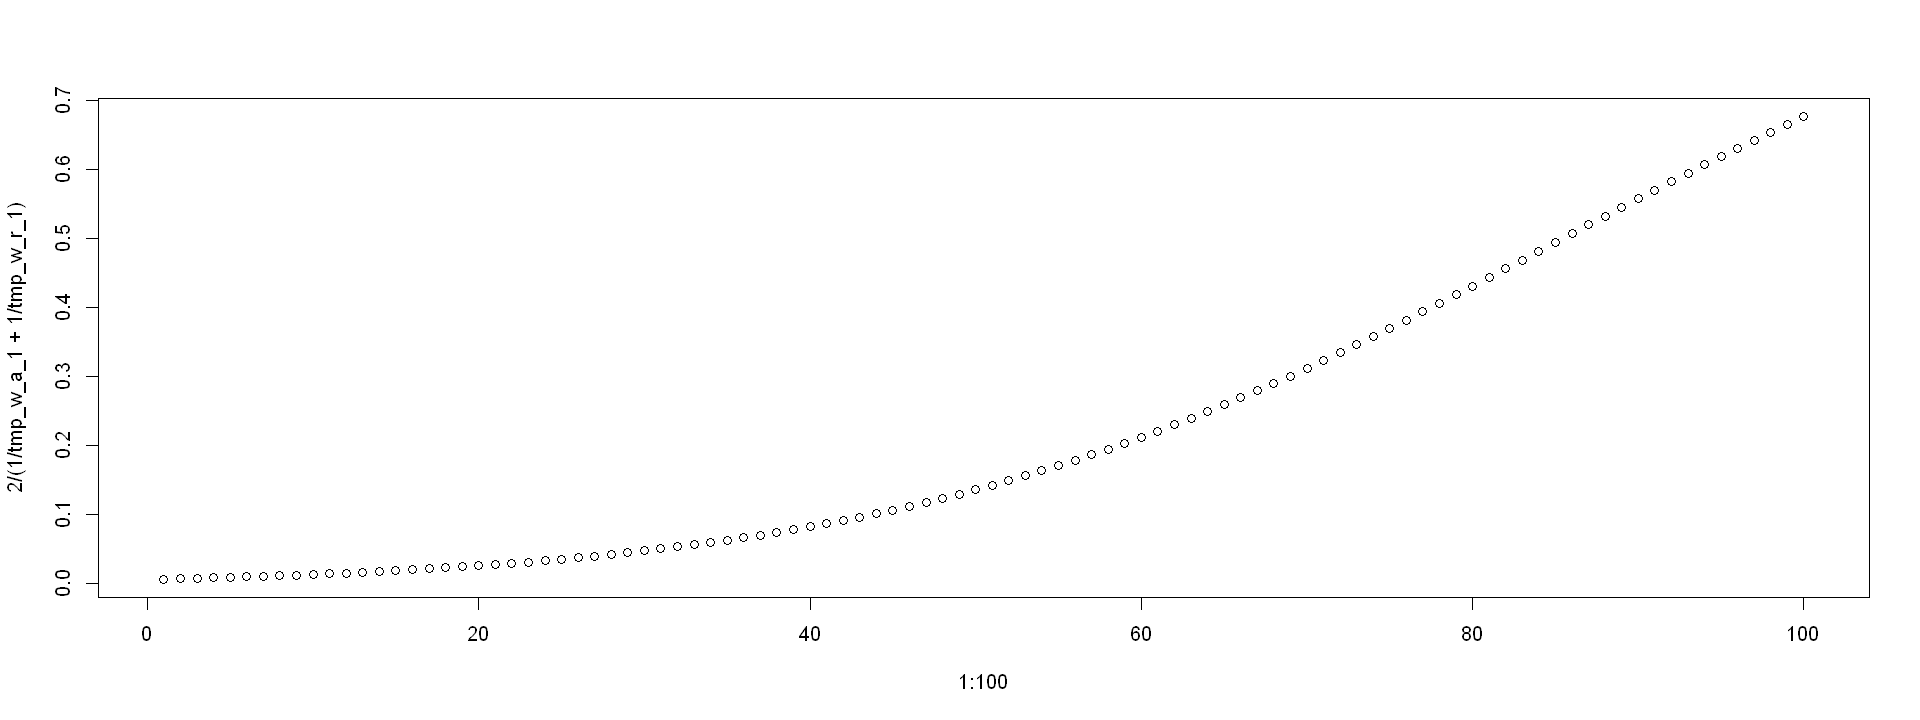

In [11]:
plot(1:100, 2/(1/tmp_w_a_1+1/tmp_w_r_1))

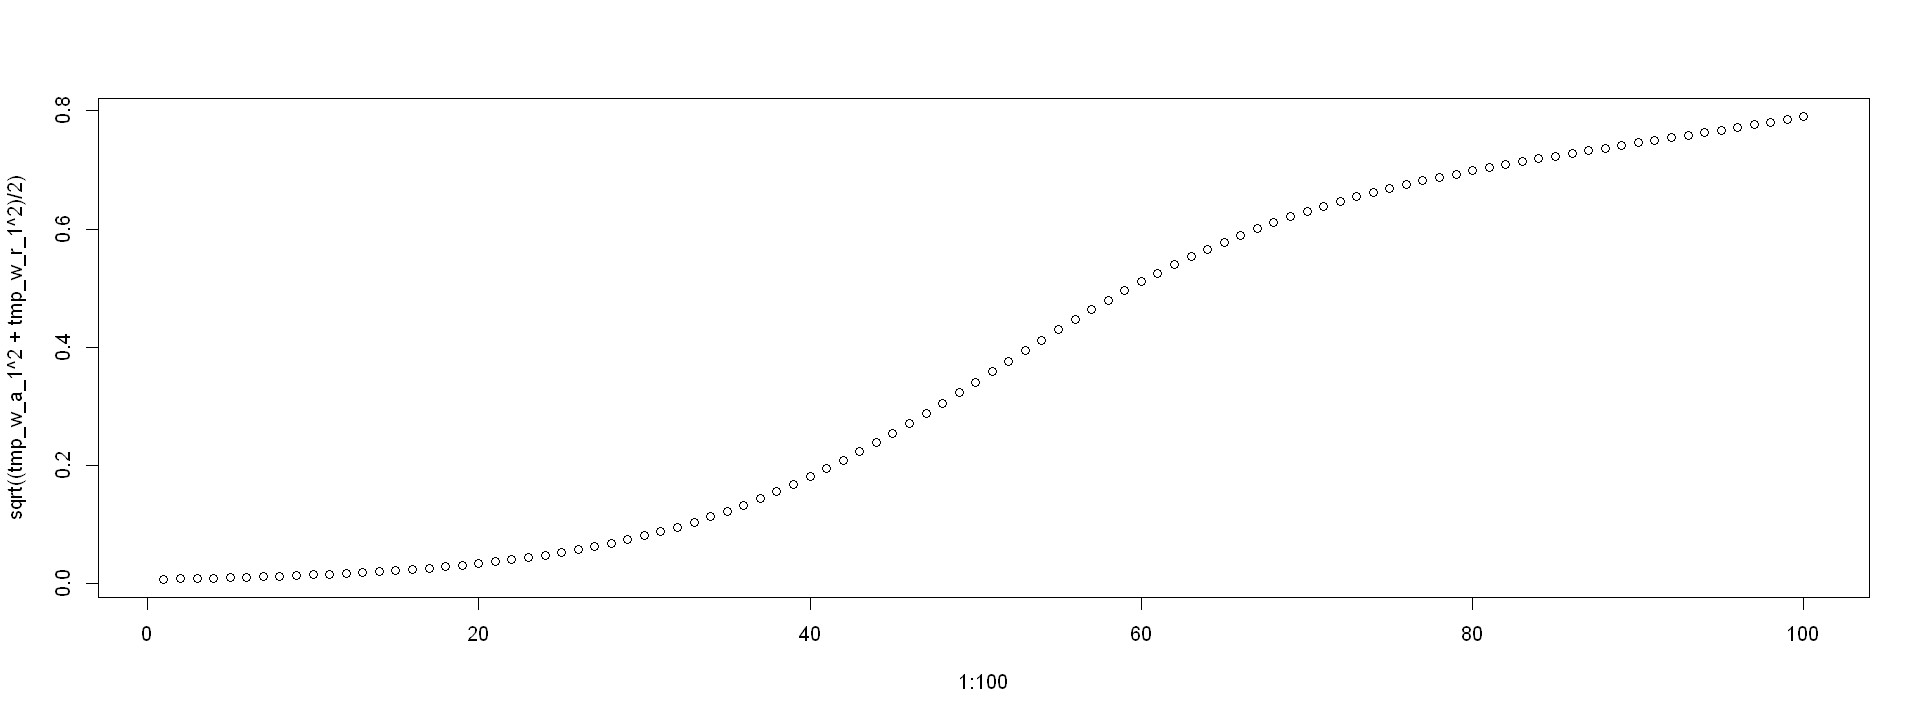

In [12]:
plot(1:100, sqrt((tmp_w_a_1^2+tmp_w_r_1^2)/2))

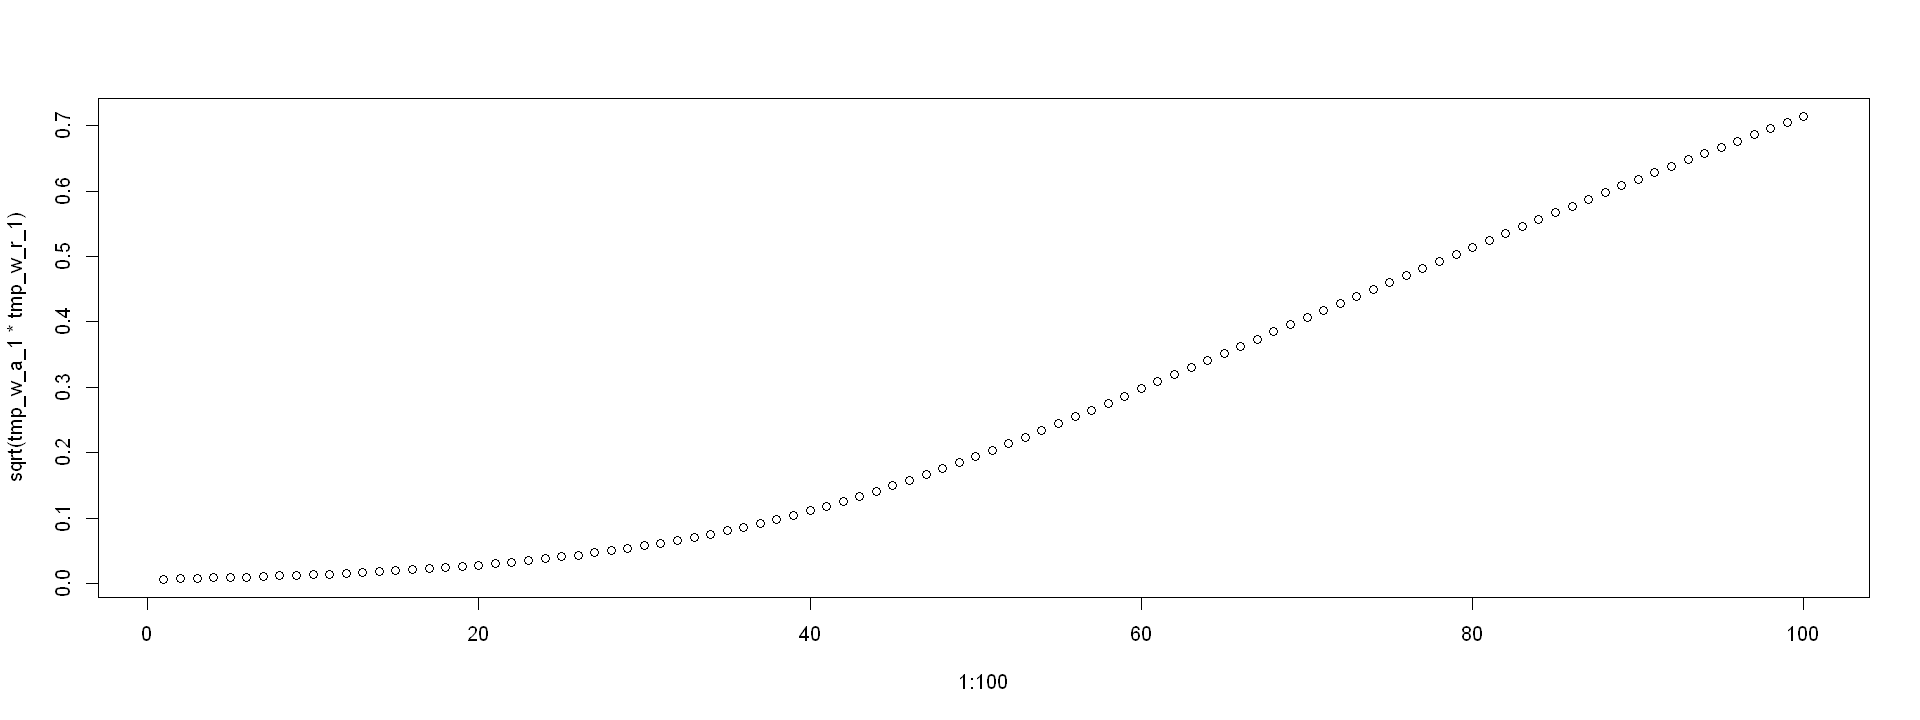

In [13]:
plot(1:100, sqrt(tmp_w_a_1*tmp_w_r_1))

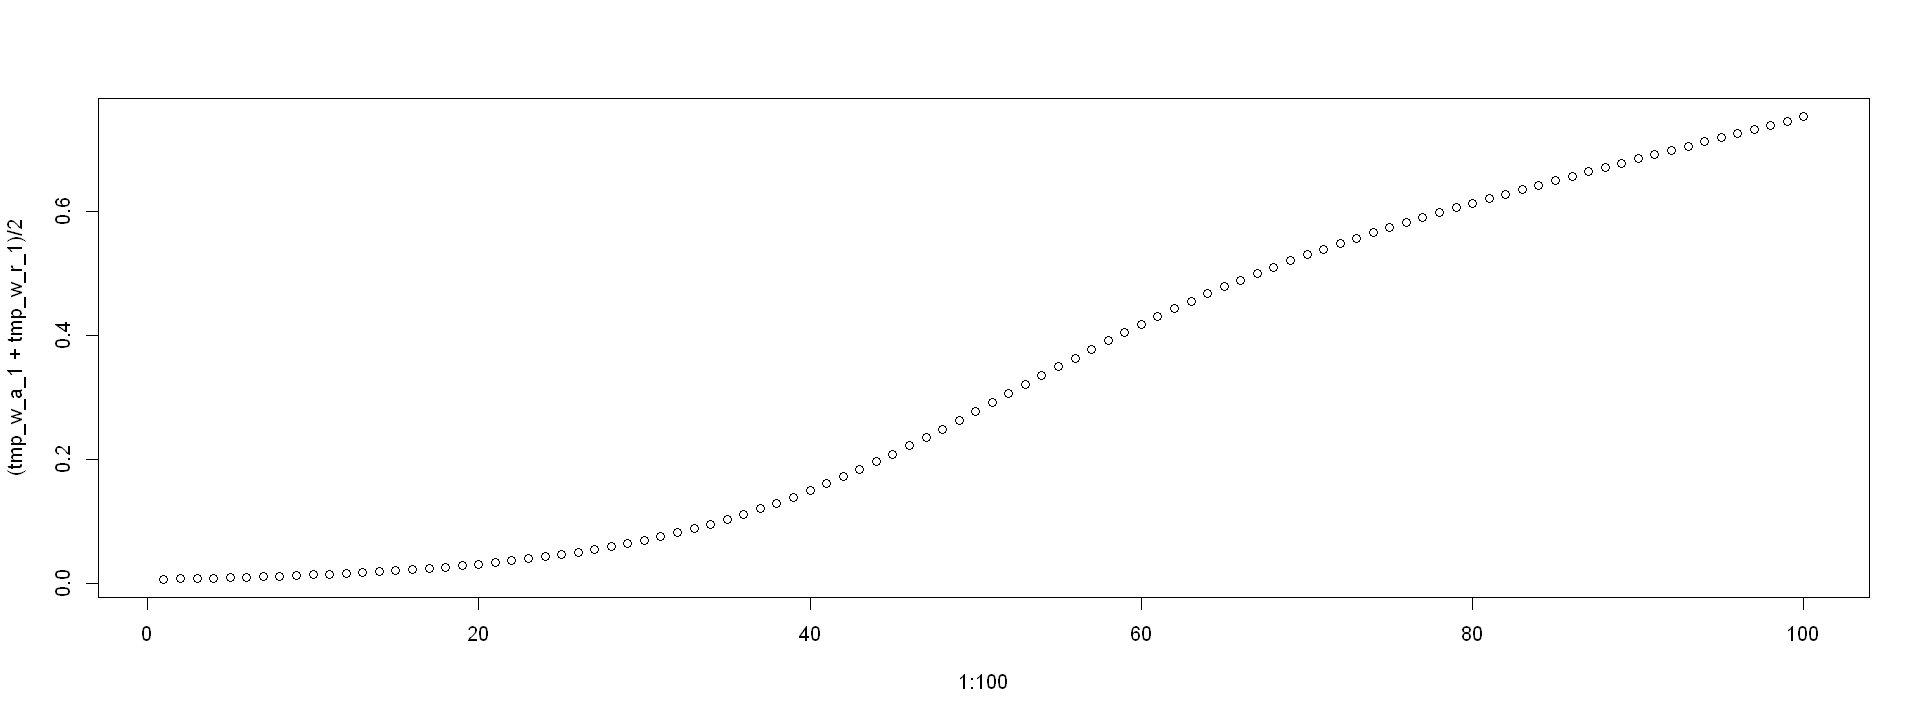

In [14]:
plot(1:100, (tmp_w_a_1 + tmp_w_r_1)/2)